# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=8):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3, cxpb=0.6)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=252)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.0007	-17.5087	14.8889
2  	693   	-113.777	21.9267	-8.36503	12.8262
3  	732   	-110.882	37.1837	-2.51751	11.9688
4  	728   	-112.792	37.1837	2.11912 	10.215 
5  	736   	-112.082	37.1837	4.595   	12.573 
6  	732   	-112.802	37.1837	7.38436 	13.3648
7  	768   	-110.882	37.1837	10.1999 	13.5792
8  	718   	-61.4806	37.1837	12.7926 	11.8978
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Best average net profit: 2.539723442717155
CPU times: user 8min 35s, sys: 437 ms, total: 8min 35s
Wall time: 8min 36s


In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[7, 43, 108], [3, 7]]
Net profit of strategy: 9.988800
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 10.957437%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 6
Number of sell signals: 6


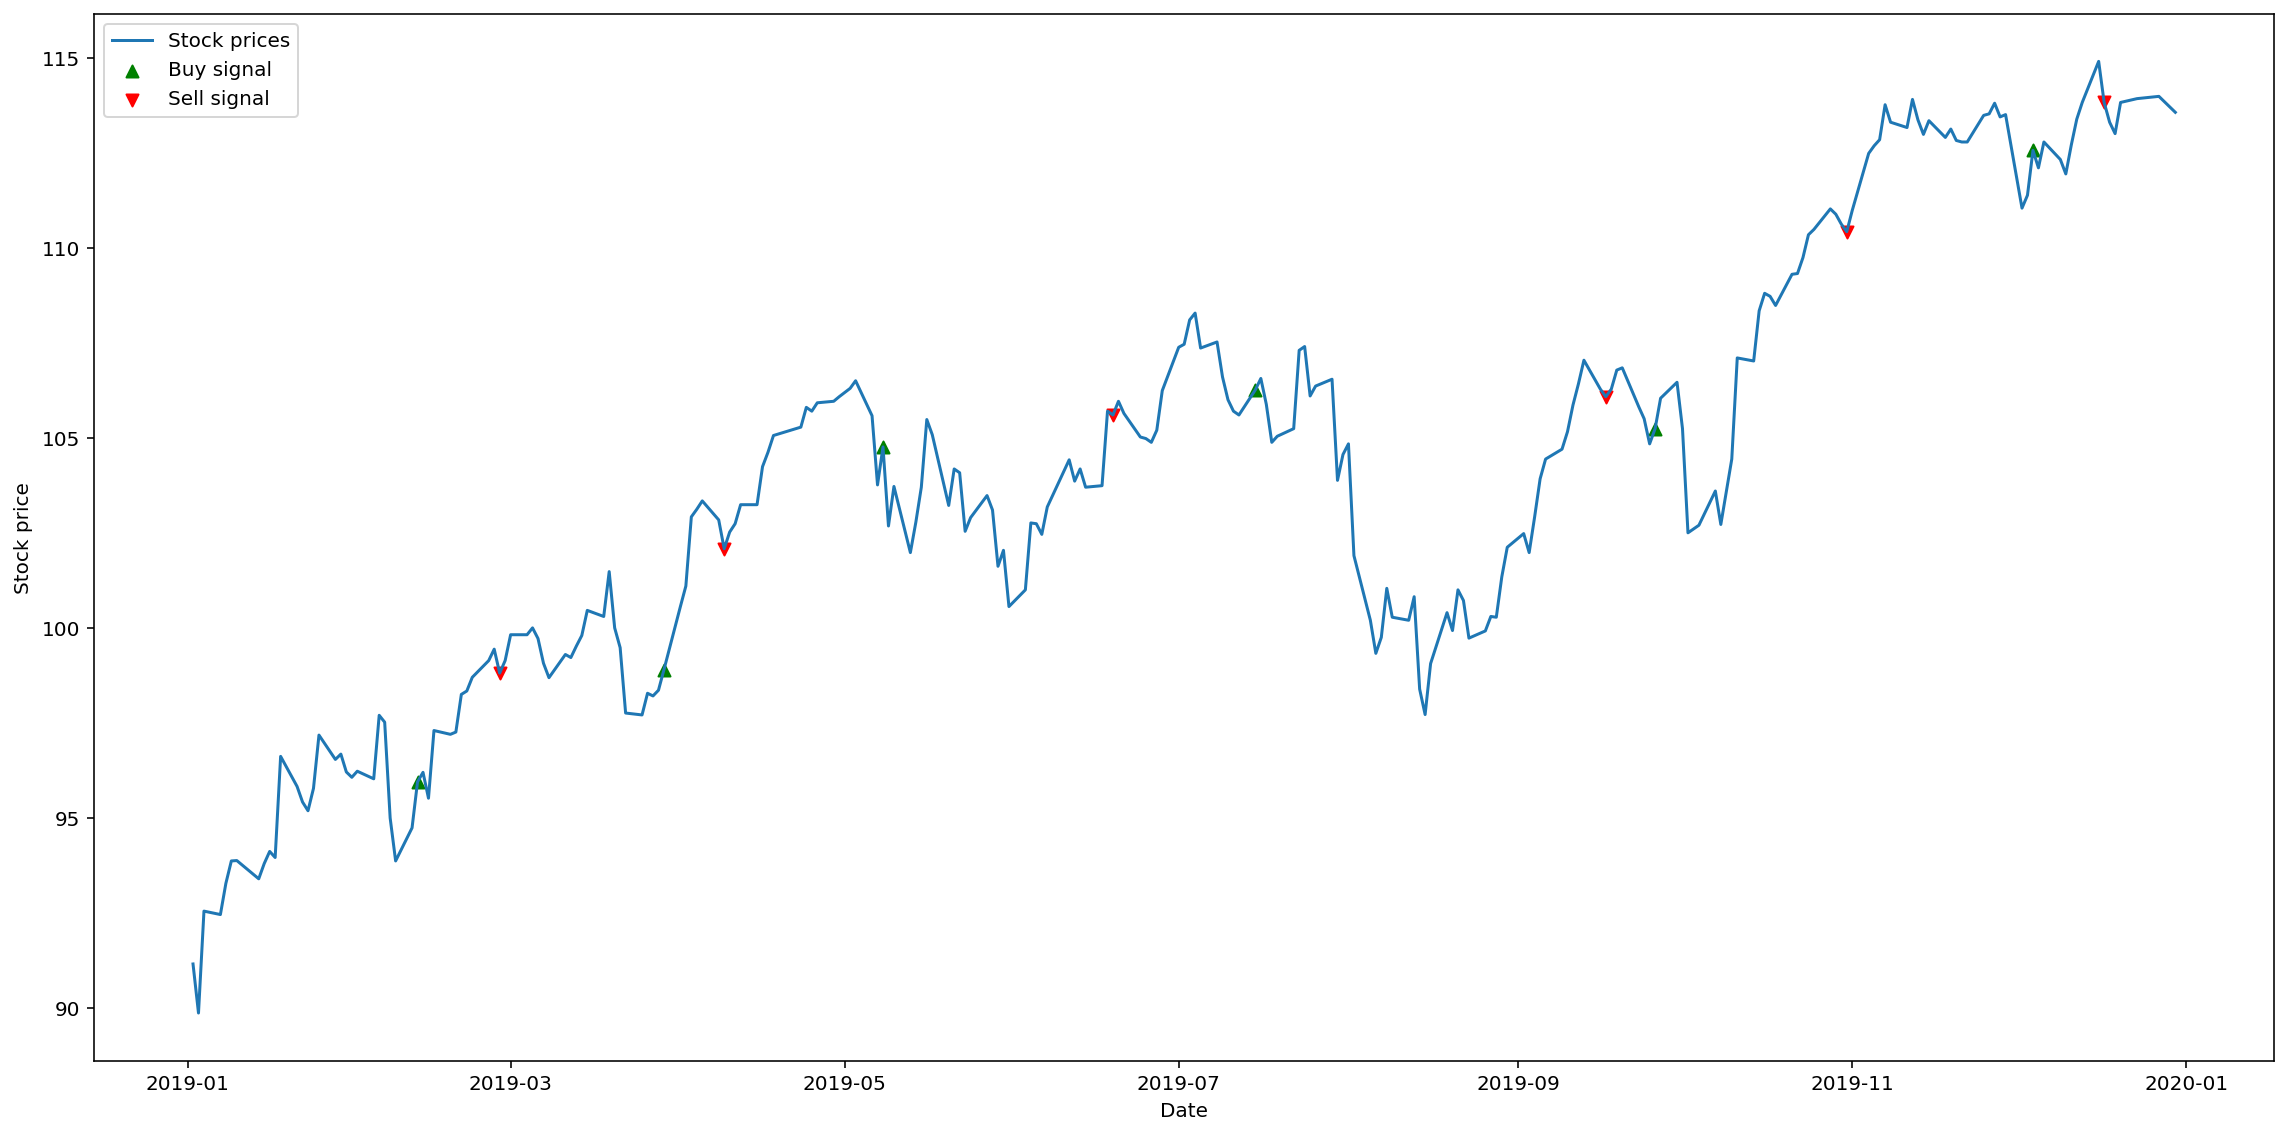

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=8)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	731   	-80.3103	88.8497	18.5164 	27.0102
2  	693   	-156.036	95.0996	33.8371 	26.3696
3  	732   	-129.626	101.916	45.0693 	25.0588
4  	728   	-132.923	112.837	54.9181 	26.8473
5  	736   	-92.54  	119.252	62.5018 	27.0326
6  	732   	-127.862	119.252	70.4196 	25.6045
7  	768   	-135.621	119.252	74.3959 	28.7845
8  	718   	-47.2129	119.252	79.9916 	24.999 
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]
Best average net profit: 44.95145519015734
CPU times: user 8min 25s, sys: 449 ms, total: 8min 25s
Wall time: 8min 26s


In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 51, 93], [59, 6]]
Net profit of strategy: 41.085200
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 23.037569%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 5
Number of sell signals: 5


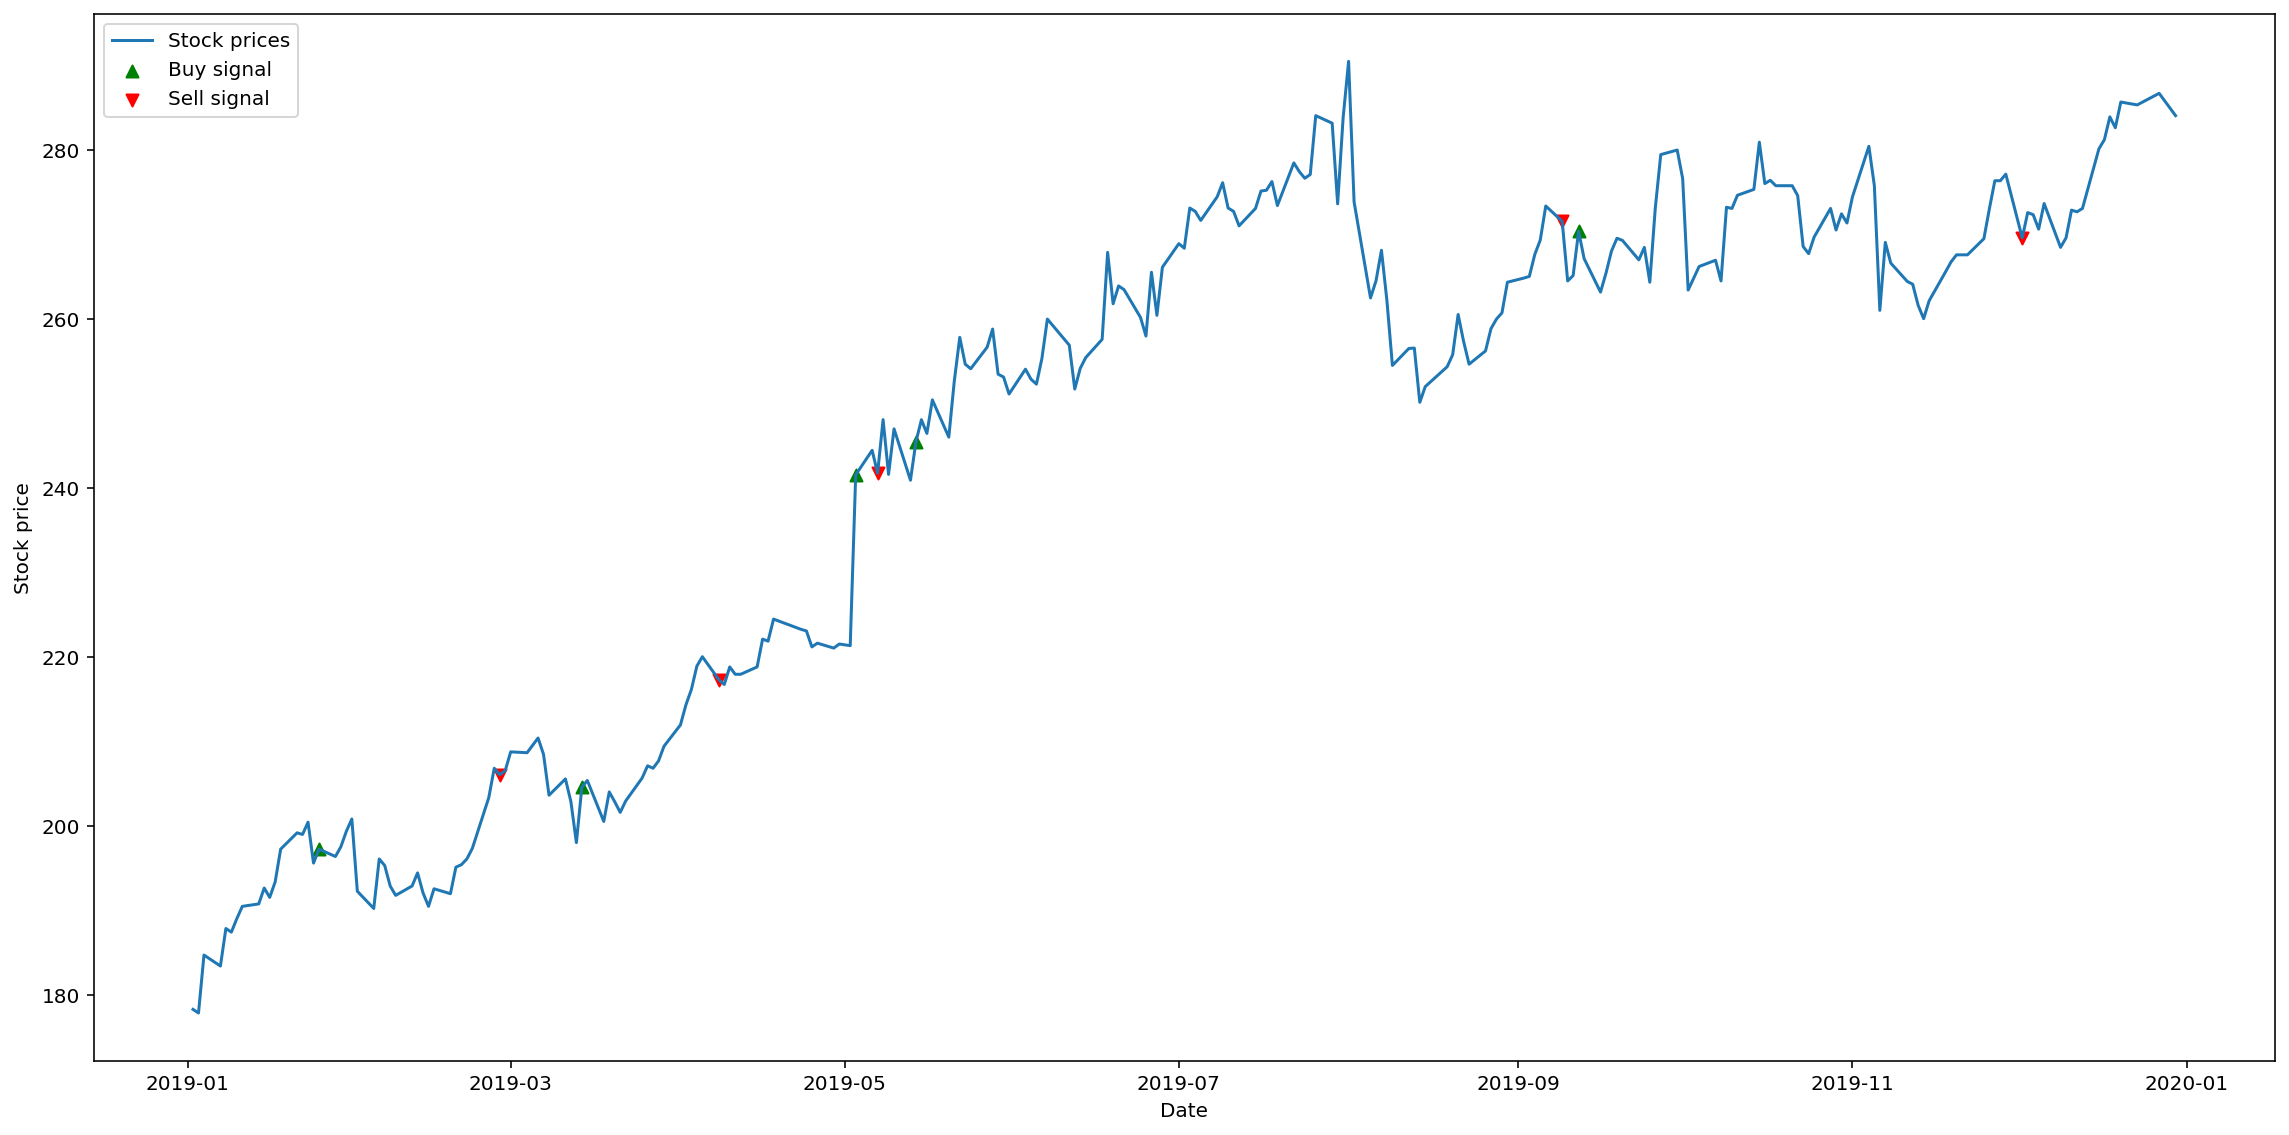

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	731   	-115.453	56.423 	-4.31258	18.0011
2  	693   	-121.845	53.7135	5.02989 	17.8957
3  	732   	-58.8245	56.423 	12.7925 	17.7901
4  	728   	-117.509	56.423 	20.3608 	18.7475
5  	736   	-58.4529	85.3045	26.2874 	19.4999
6  	732   	-113.269	85.3045	32.3214 	19.6355
7  	768   	-115.619	85.3045	37.5371 	21.1602
8  	718   	-120.132	85.3045	43.762  	19.6145
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Best average net profit: 18.6007156100657
CPU times: user 7min 43s, sys: 426 ms, total: 7min 44s
Wall time: 7min 44s


In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[12, 51, 120], [61, 7]]
Net profit of strategy: 31.475325
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 19.984333%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 5
Number of sell signals: 5


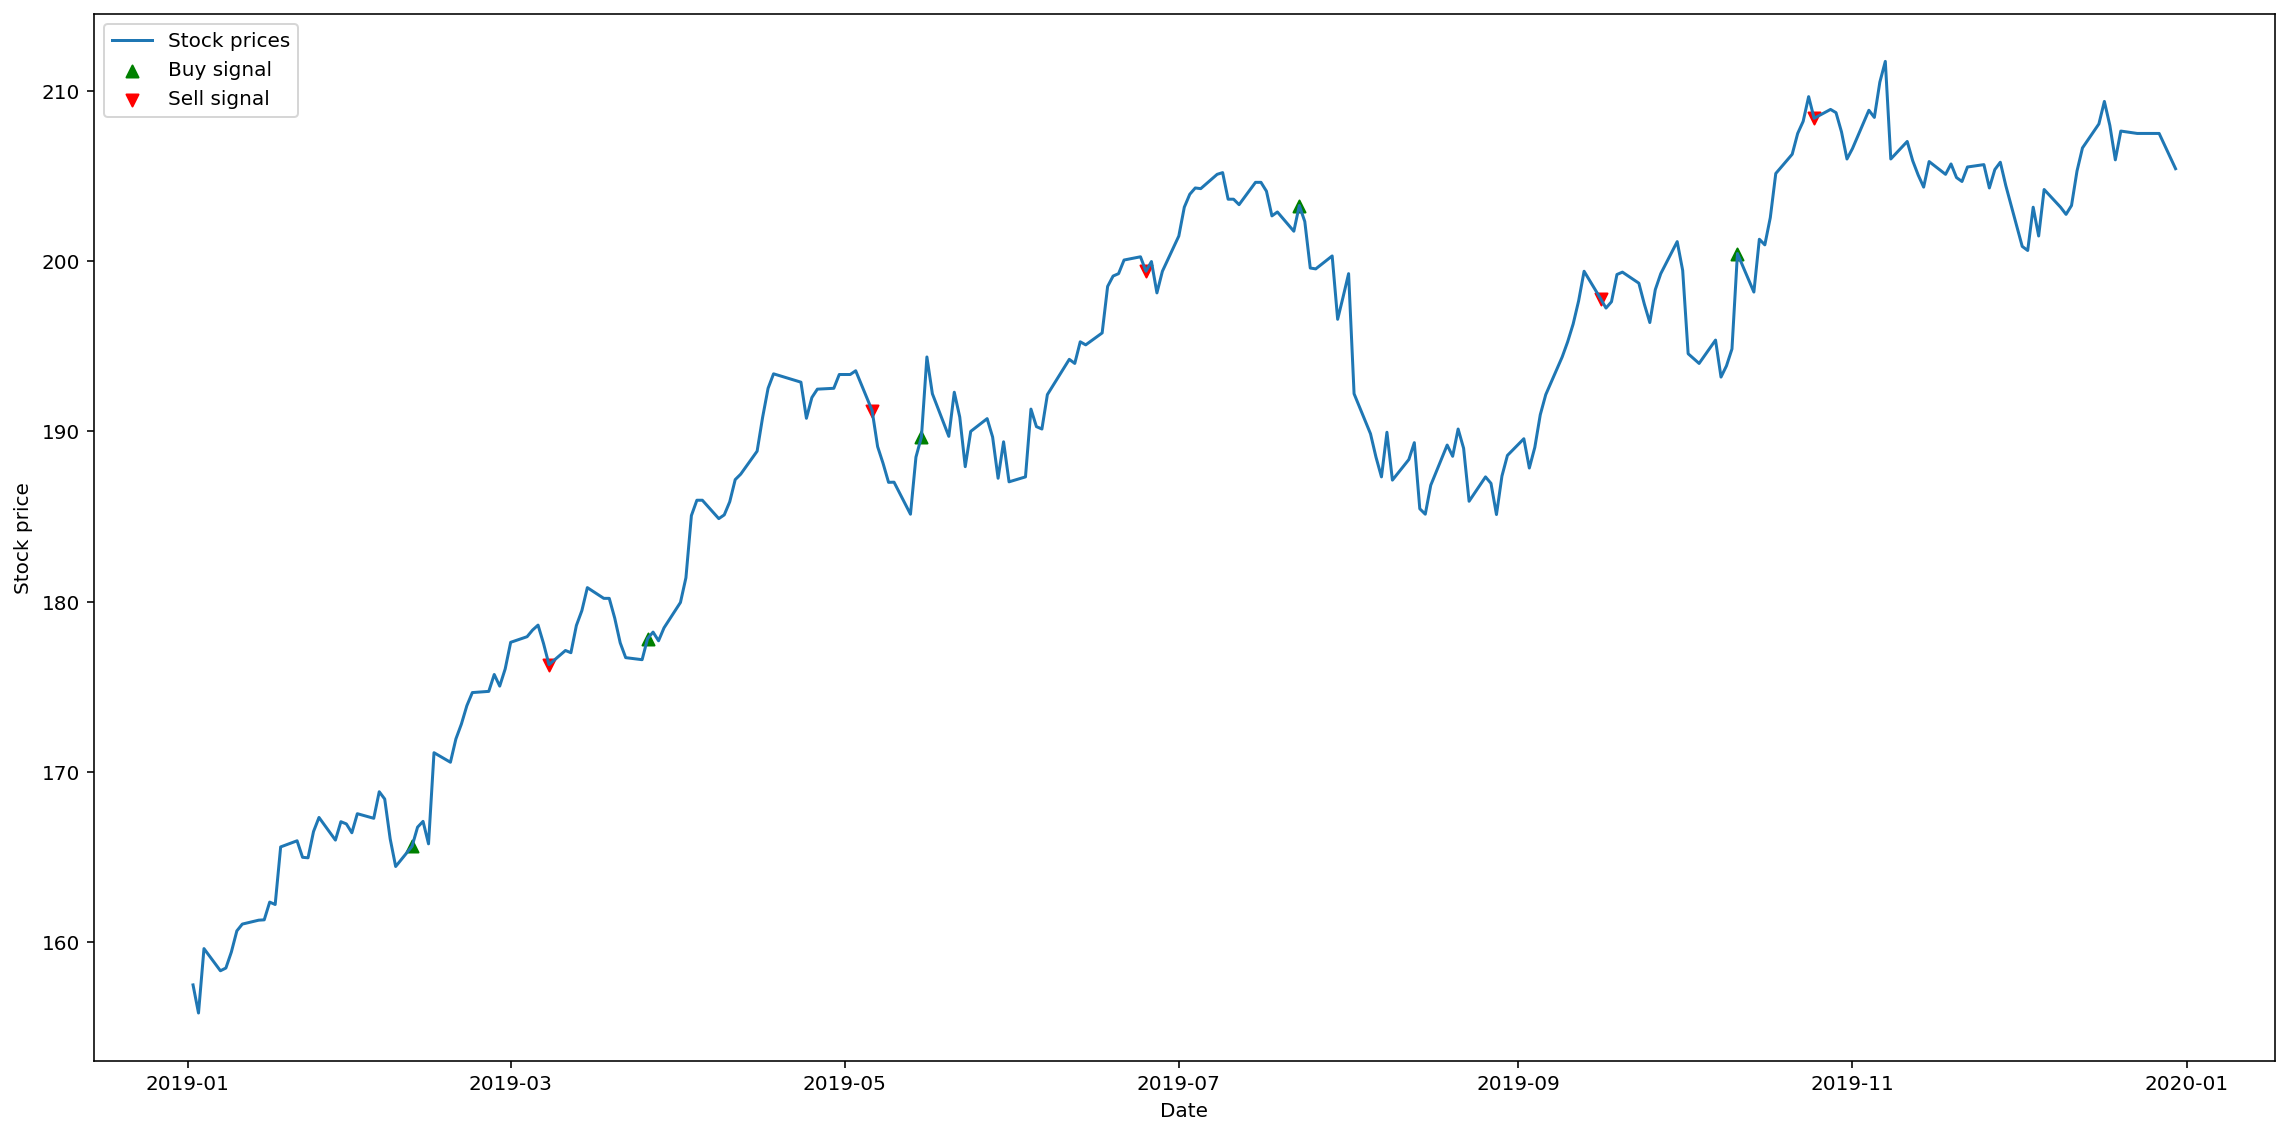

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	731   	-63.9956	21.1967	-4.62301	9.7486 
2  	693   	-58.7963	23.1415	0.845654	8.42652
3  	732   	-68.7631	26.8883	4.40702 	9.26637
4  	728   	-69.5671	26.8883	7.29952 	9.13642
5  	736   	-59.2563	26.9266	10.0356 	9.33702
6  	732   	-58.7963	34.2378	11.8891 	10.1574
7  	768   	-58.7963	34.2378	13.2849 	10.8139
8  	718   	-58.7963	34.2378	15.9145 	10.7155
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Best average net profit: 0.7510494116639266
CPU times: user 8min 42s, sys: 658 ms, total: 8min 43s
Wall time: 8min 44s


In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[6, 126, 120], [5, 5]]
Net profit of strategy: 4.791125
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 9.459279%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 5
Number of sell signals: 5


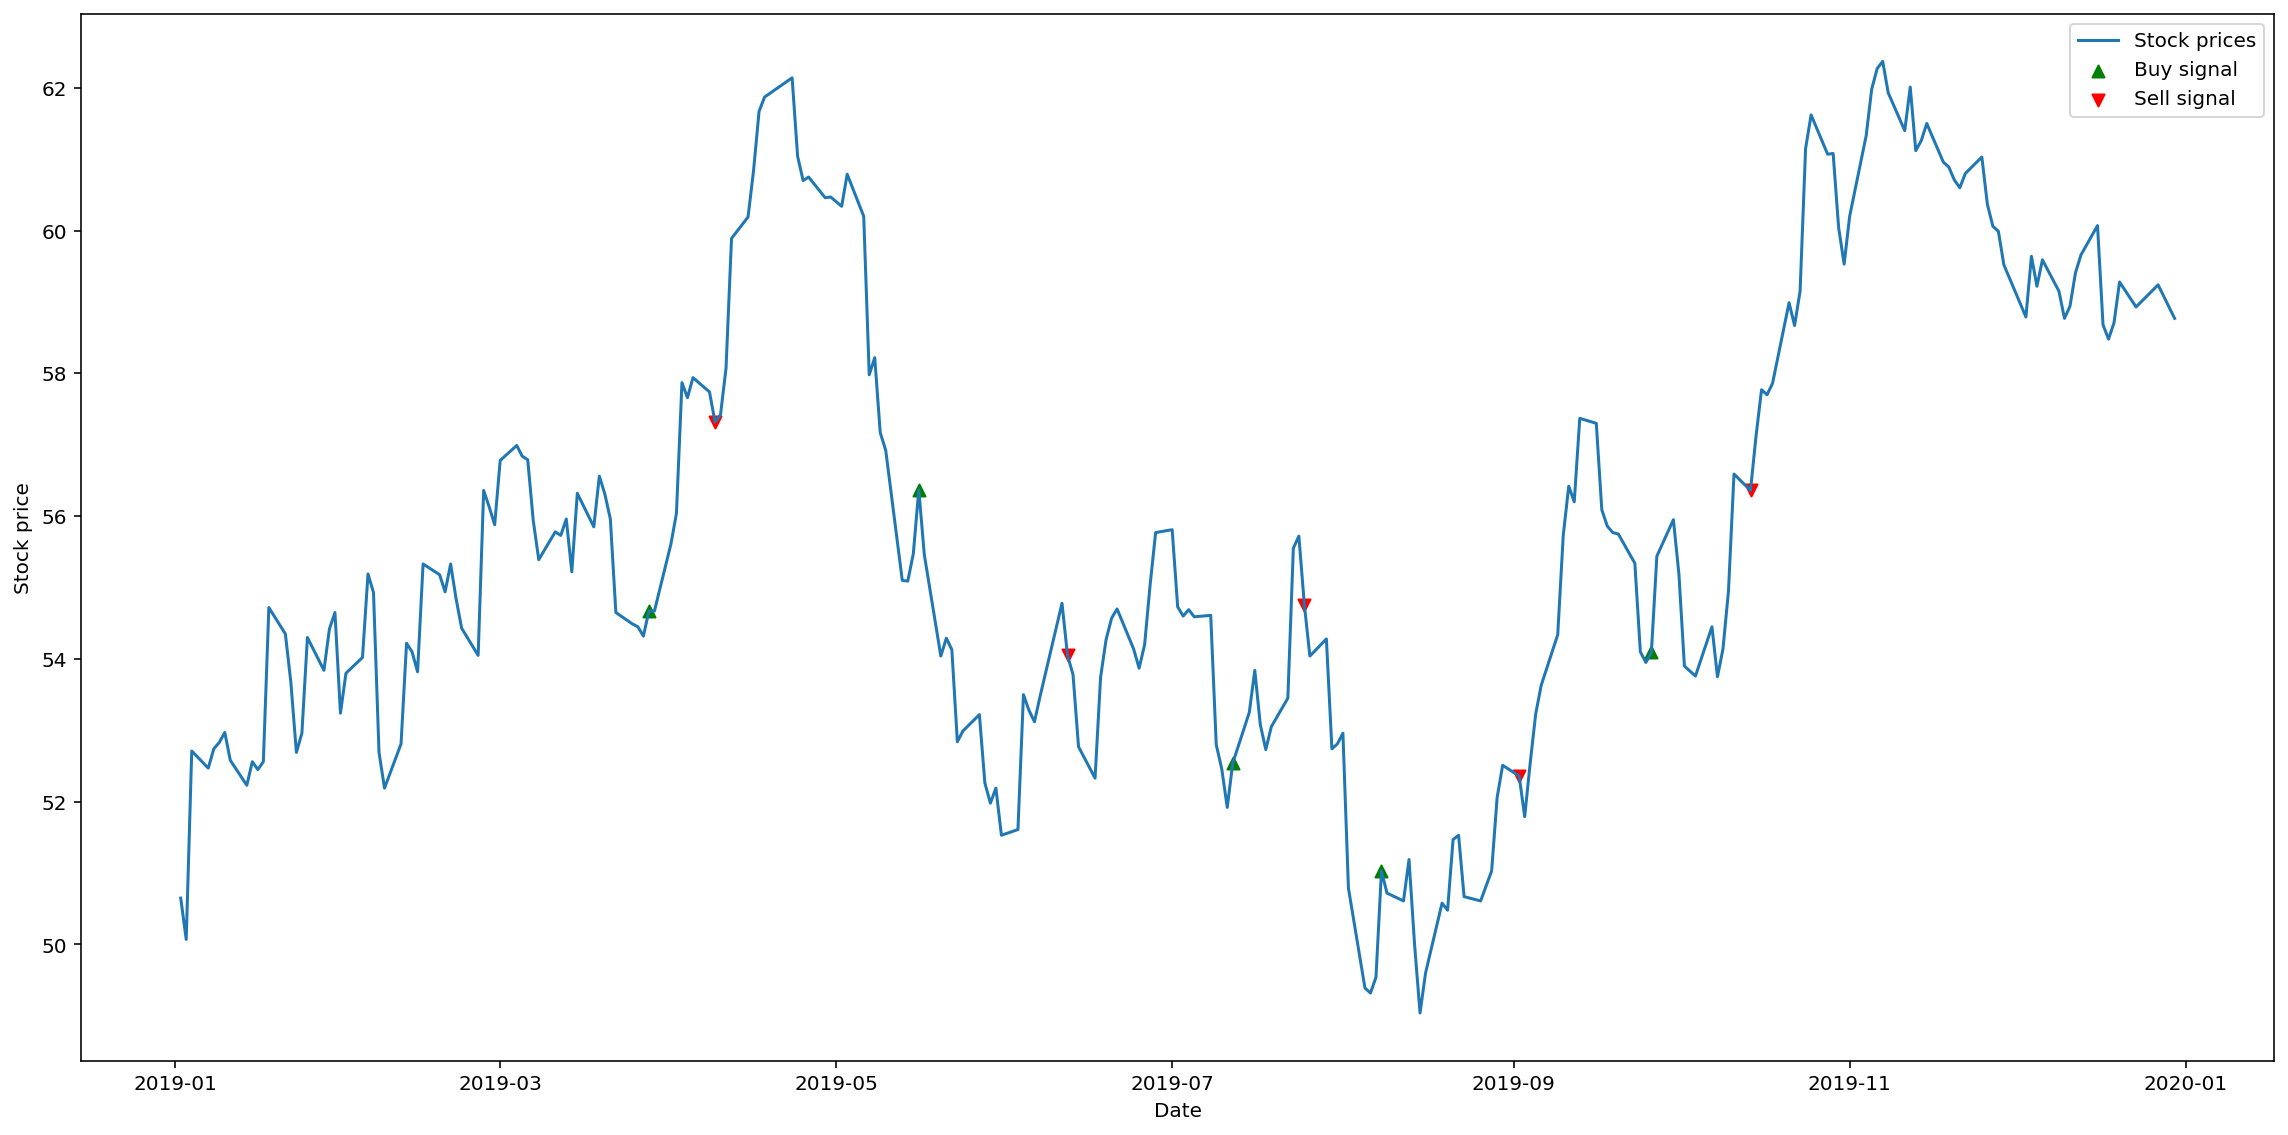

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	731   	-13.8199	3.63205	-2.69067	2.79076
2  	693   	-13.676 	5.8388 	-1.29094	2.3747 
3  	732   	-10.1599	5.81635	-0.3485 	2.26073
4  	728   	-11.8903	9.39517	0.13787 	2.45803
5  	736   	-13.4124	9.39517	0.534795	2.57124
6  	732   	-14.1071	6.90175	1.02392 	2.62438
7  	768   	-11.418 	8.5694 	1.39419 	2.85635
8  	718   	-11.7123	9.94975	2.01438 	2.9885 
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: -0.2711575274262989
CPU times: user 9min 9s, sys: 694 ms, total: 9min 10s
Wall time: 9min 10s


In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[13, 125, 59], [213], [28, 7]]
Net profit of strategy: -0.064025
Net profit of buy and hold: -0.144875
Percentage profit of strategy: -0.910740%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 1
Number of sell signals: 1


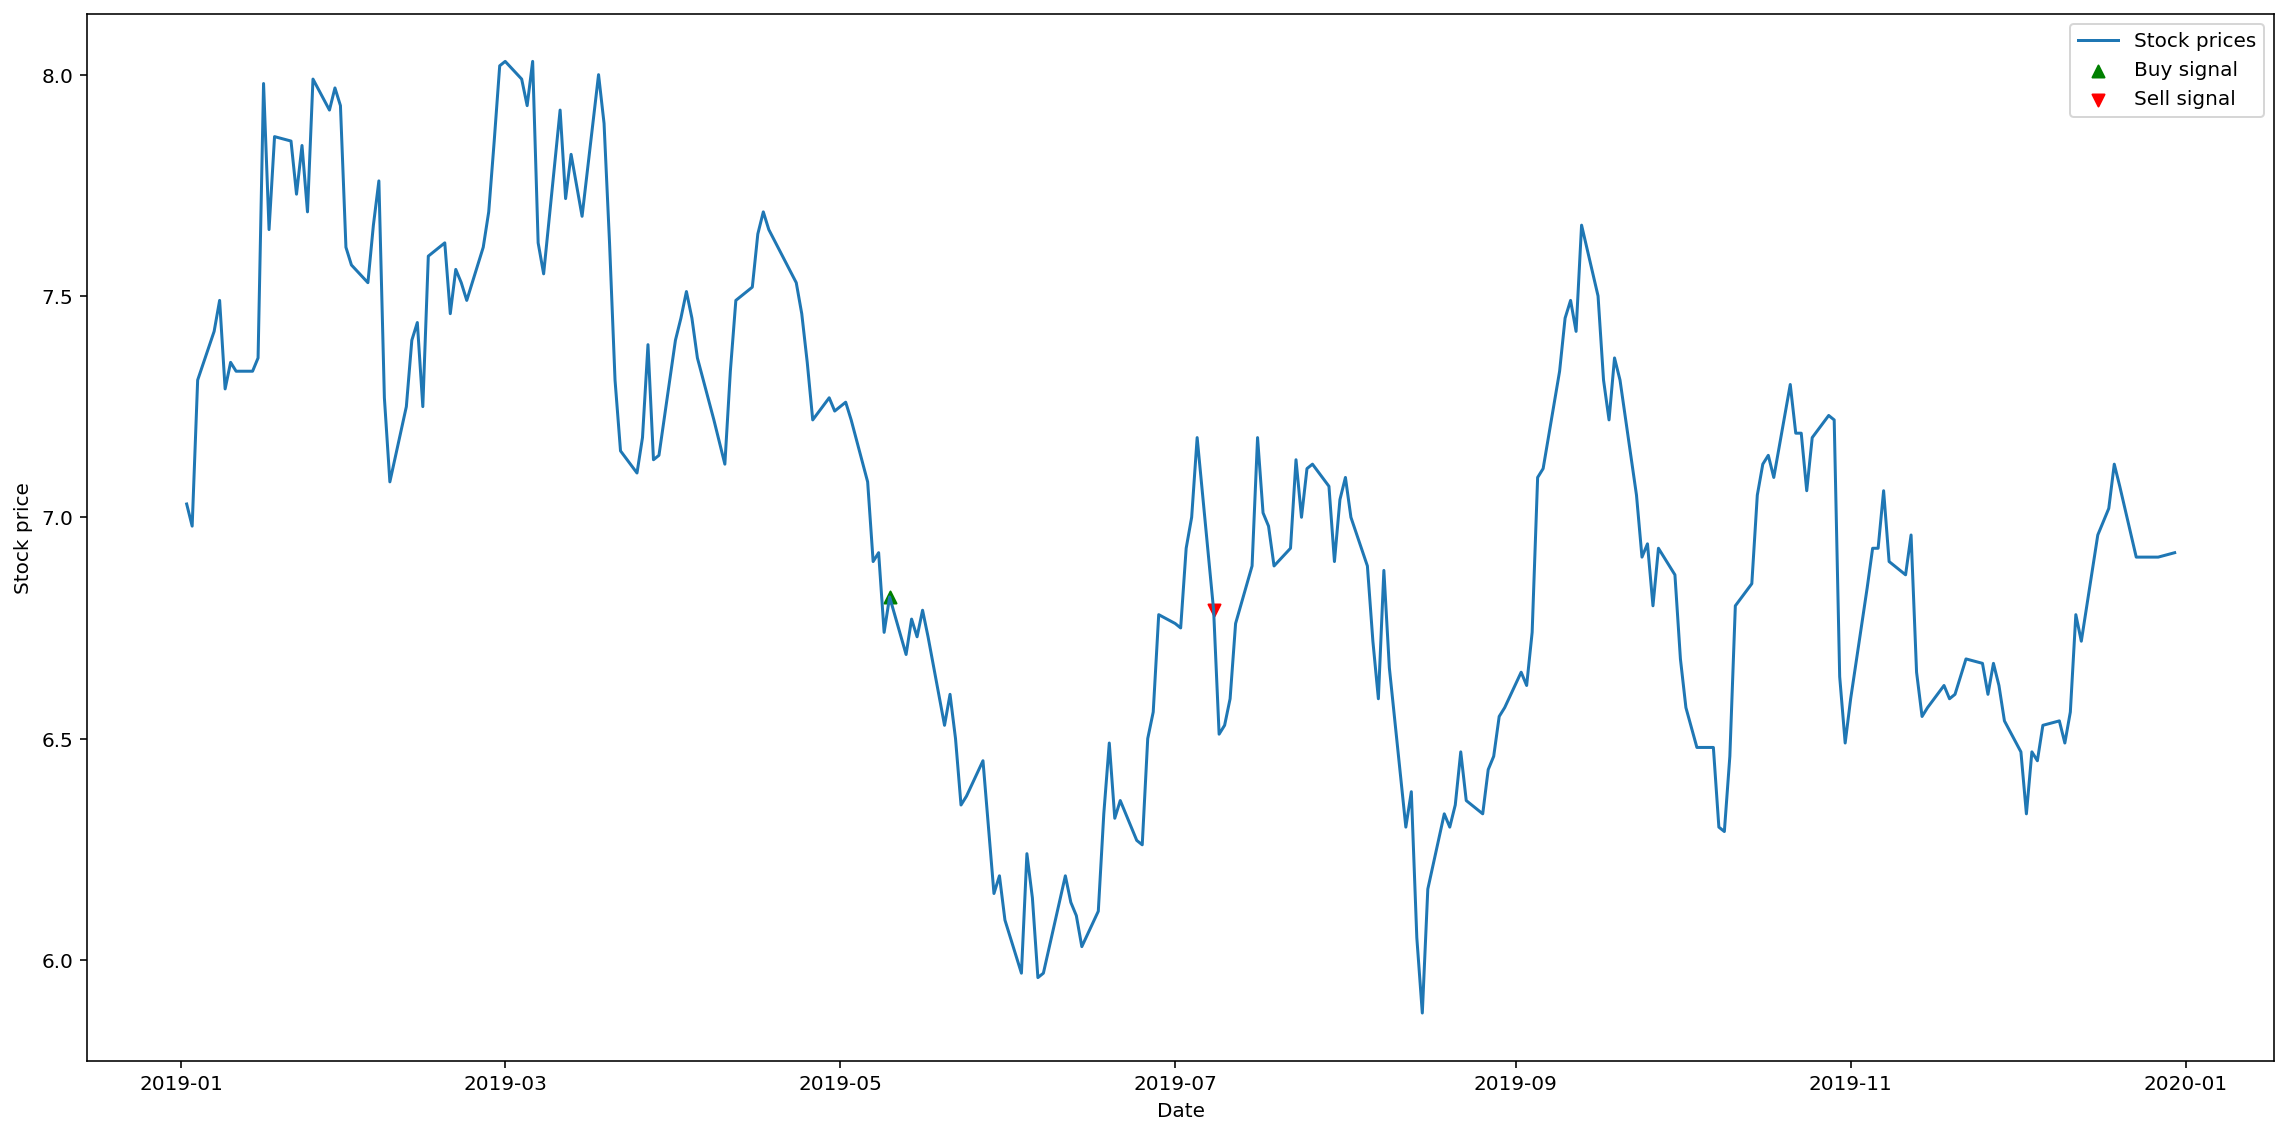

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	731   	-10.8318	2.826	-1.44041	1.88254
2  	693   	-10.2007	3.75125	-0.357609	1.58438
3  	732   	-5.75385	4.14698	0.380388 	1.36025
4  	728   	-9.85022	4.0246 	0.810758 	1.50945
5  	736   	-9.89428	4.96212	1.20319  	1.71389
6  	732   	-9.65212	4.96212	1.7502   	1.80111
7  	768   	-10.3976	5.10762	2.24385  	1.82486
8  	718   	-10.4667	5.2995 	2.73024  	1.88662
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
Best average net profit: 0.25525290310228643
CPU times: user 9min 8s, sys: 665 ms, total: 9min 8s
Wall time: 9min 9s


In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[138, 243], [17, 38, 121], [117], [35, 7]]
Net profit of strategy: 1.834175
Net profit of buy and hold: 0.314450
Percentage profit of strategy: 14.196401%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 2
Number of sell signals: 2


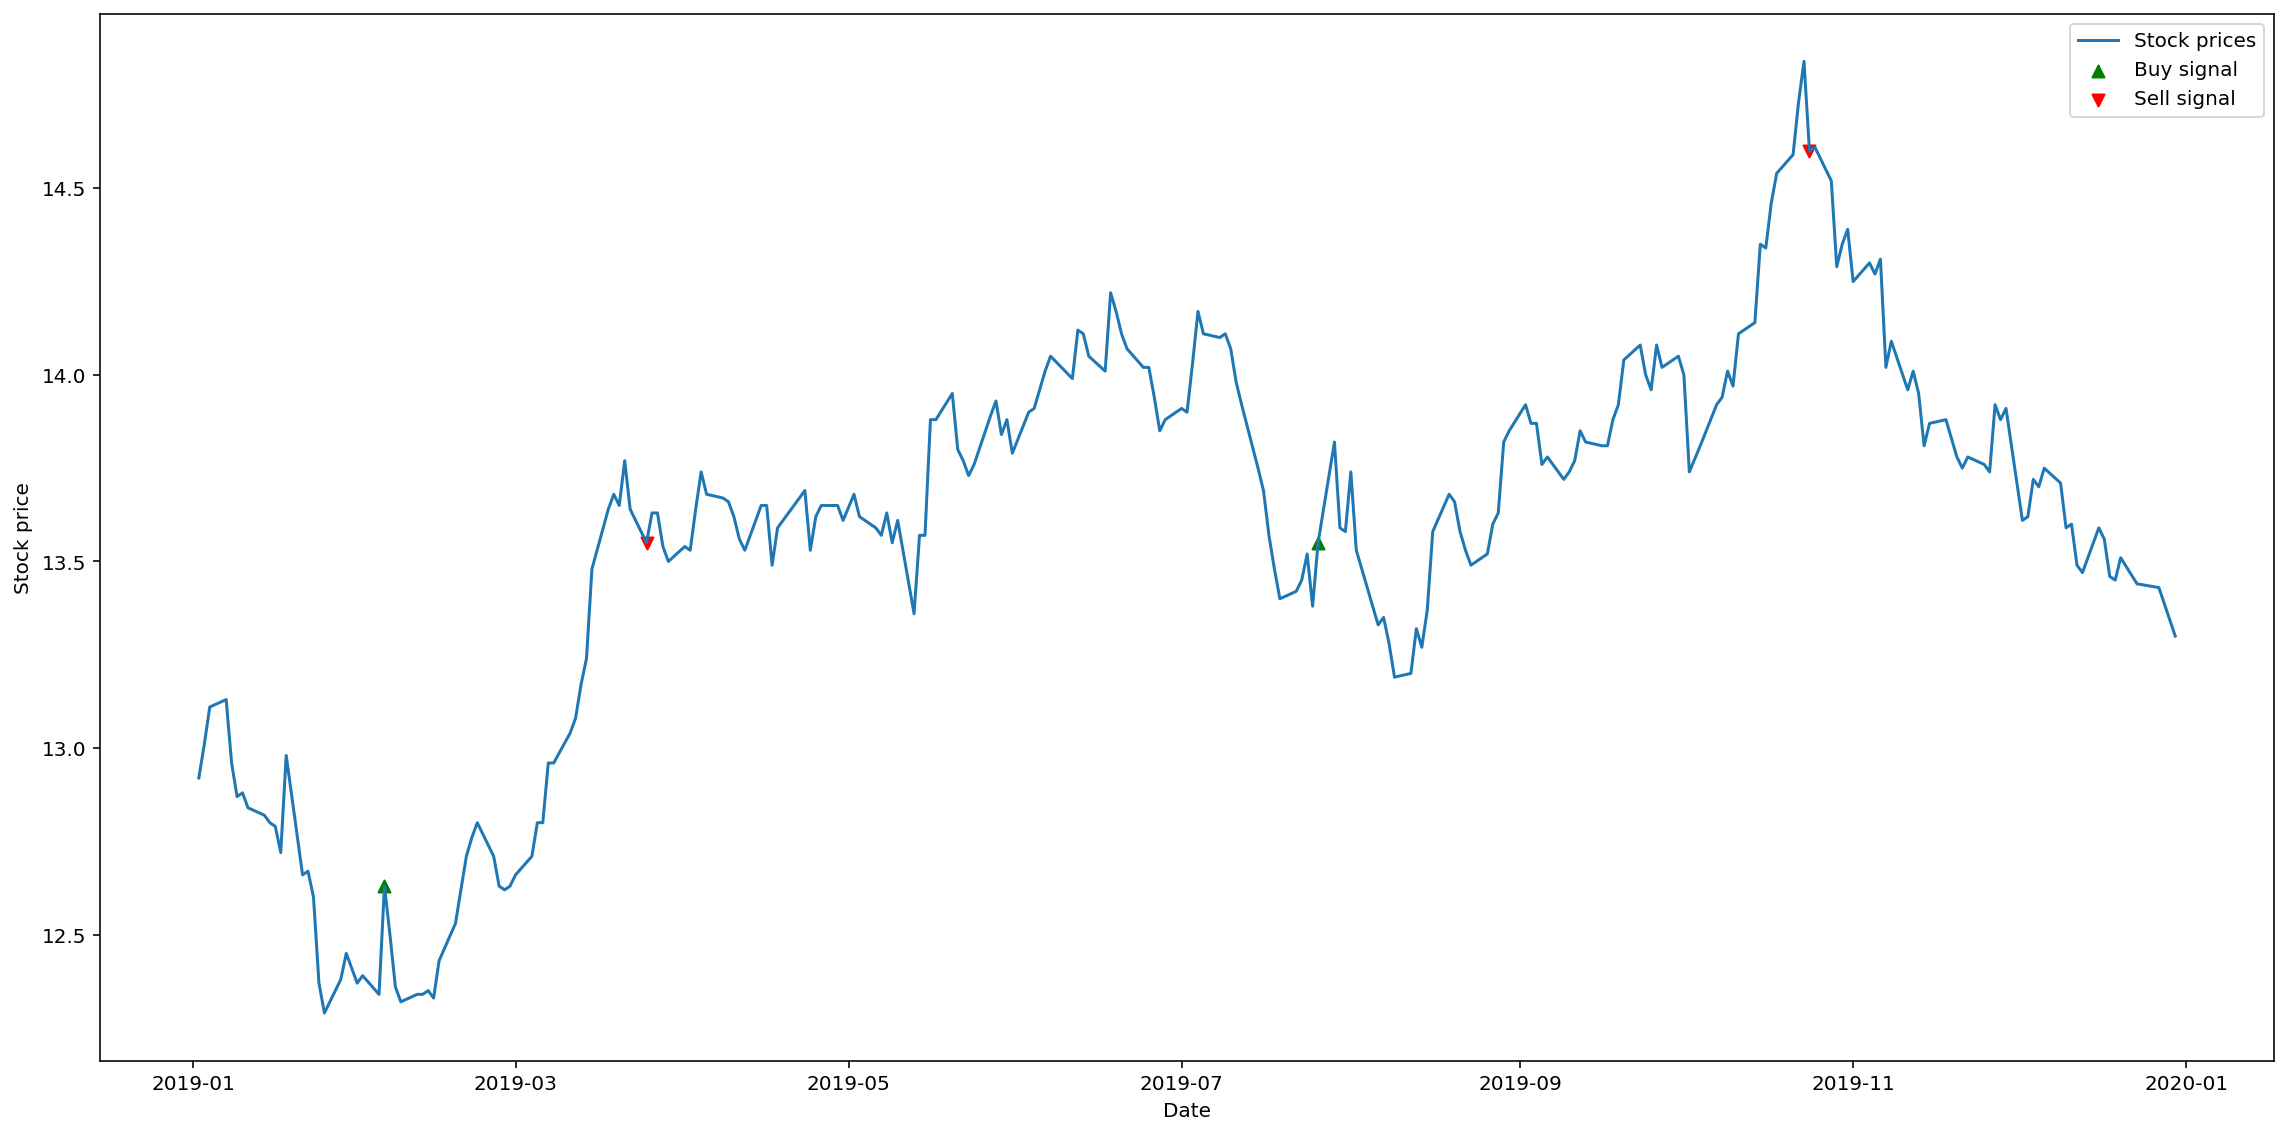

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	731   	-75.559 	26.6214	-2.84961	11.8627
2  	693   	-77.6088	26.6214	3.86998 	9.65979
3  	732   	-72.3062	29.9904	7.34115 	11.2872
4  	728   	-77.2148	29.9904	10.4799 	12.1346
5  	736   	-72.8054	30.1816	13.6613 	11.2091
6  	732   	-42.4596	37.0555	15.5433 	10.9857
7  	768   	-76.6172	39.0521	16.2422 	13.3926
8  	718   	-73.6686	48.3655	17.4748 	13.7796
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Best average net profit: 3.0526887444267317
CPU times: user 9min 42s, sys: 702 ms, total: 9min 42s
Wall time: 9min 43s


In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[205, 198], [9, 36, 110], [59], [62, 7]]
Net profit of strategy: 8.798350
Net profit of buy and hold: 32.969475
Percentage profit of strategy: 10.553377%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 4
Number of sell signals: 4


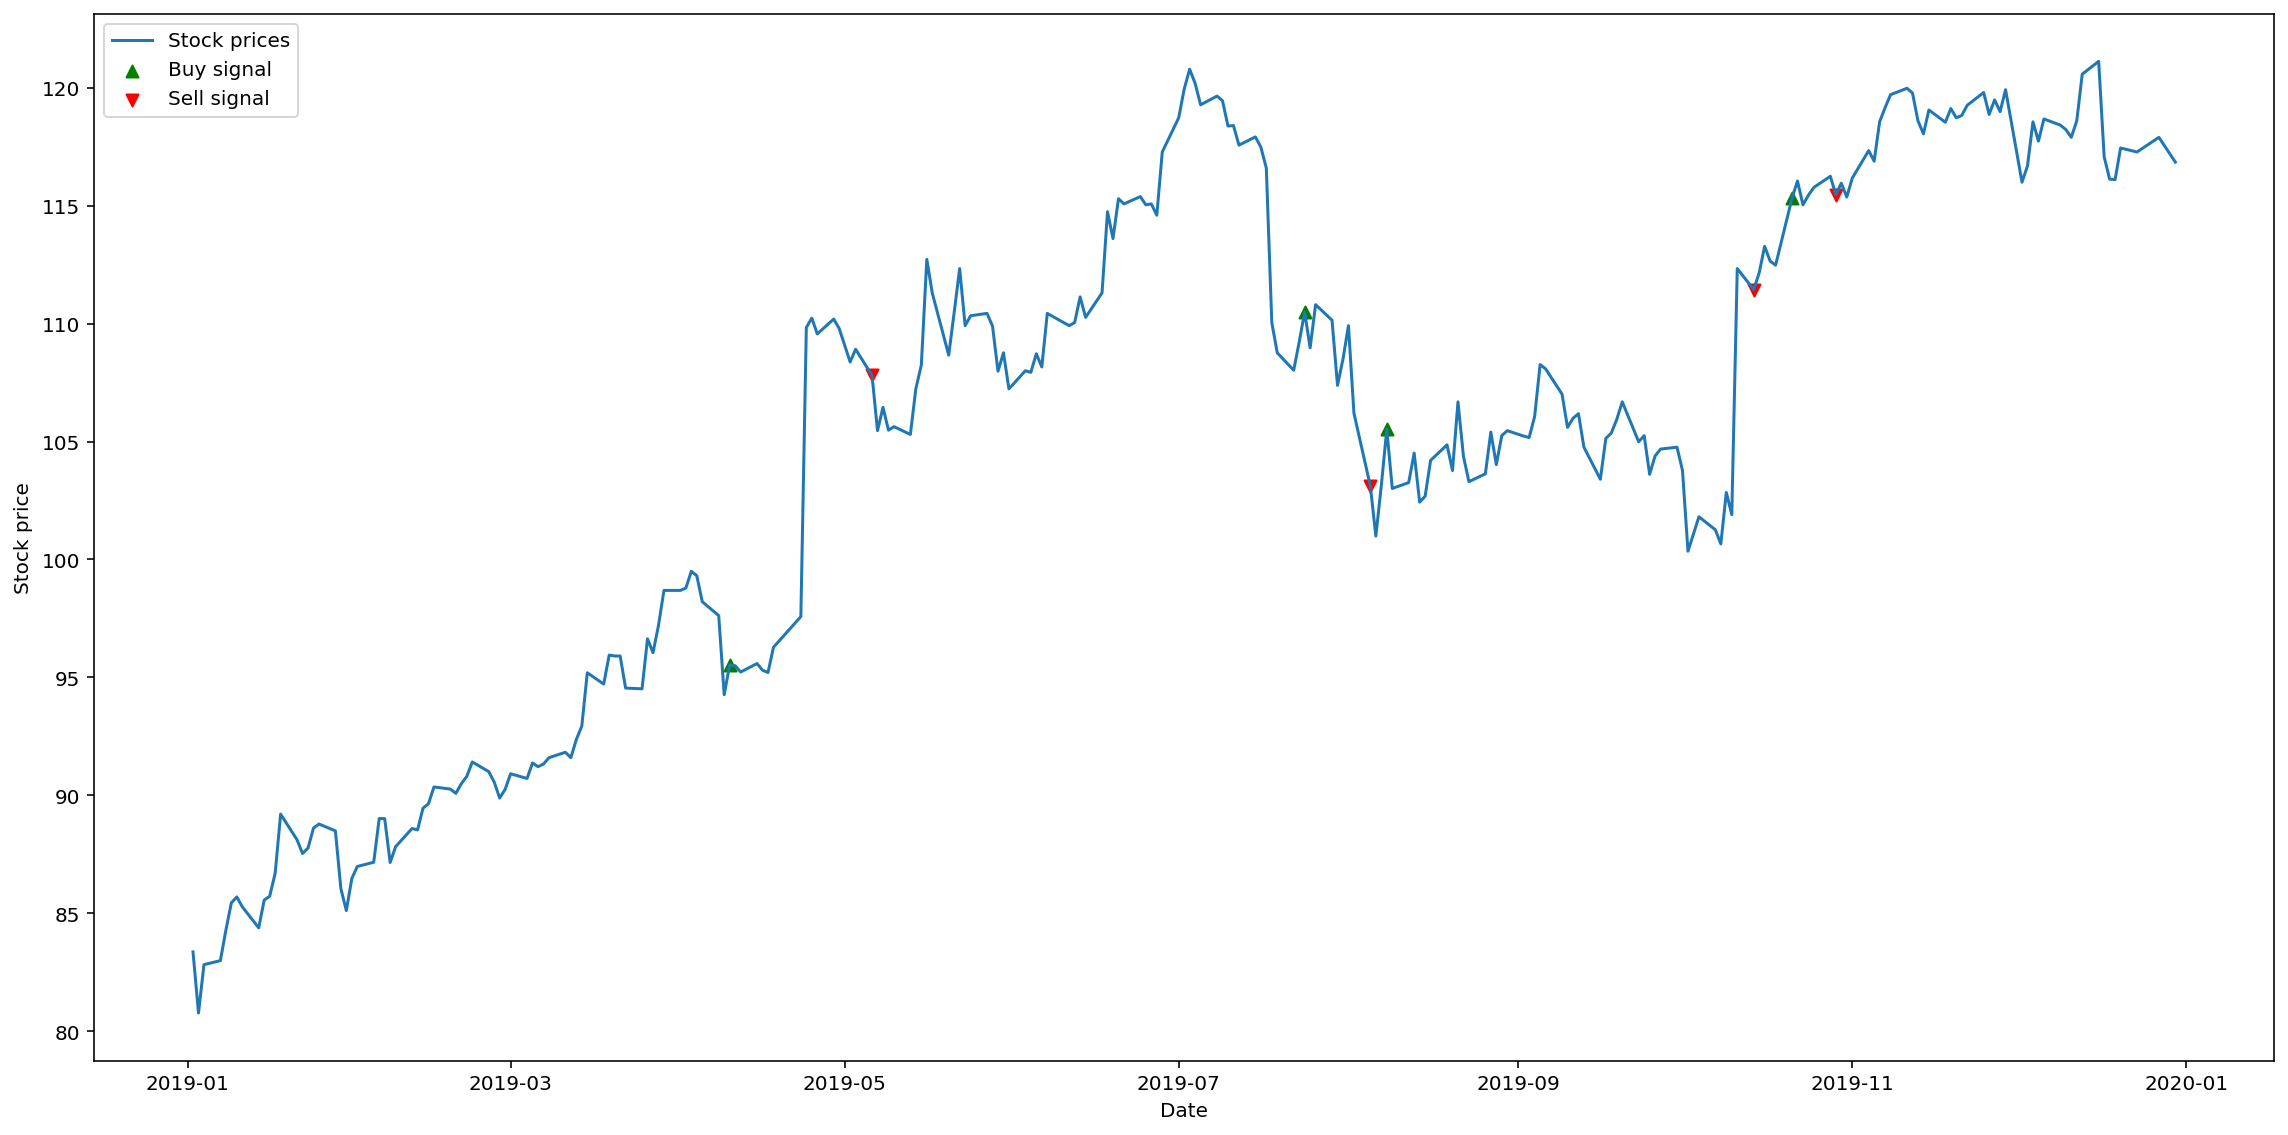

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	731   	-17338.5	7497.34	1243.51 	2302.12
2  	693   	-15804.2	7739.14	2384.9  	2013.78
3  	732   	-14277.9	7532.41	3080.08 	2233.36
4  	728   	-10030.5	8421.21	3817.42 	1874.78
5  	736   	-17074.8	8421.21	4260.11 	2325.39
6  	732   	-10254.9	8421.21	4665.4  	2117.9 
7  	768   	-18104.5	8659.32	4881.61 	2588.7 
8  	718   	-12314.8	9601.51	5351.59 	2396.27
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Best average net profit: 525.4372516113364
CPU times: user 9min 2s, sys: 591 ms, total: 9min 2s
Wall time: 9min 3s


In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[1], [175, 87, 56], [32, 5]]
Net profit of strategy: 1615.827250
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 6.922788%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 6
Number of sell signals: 6


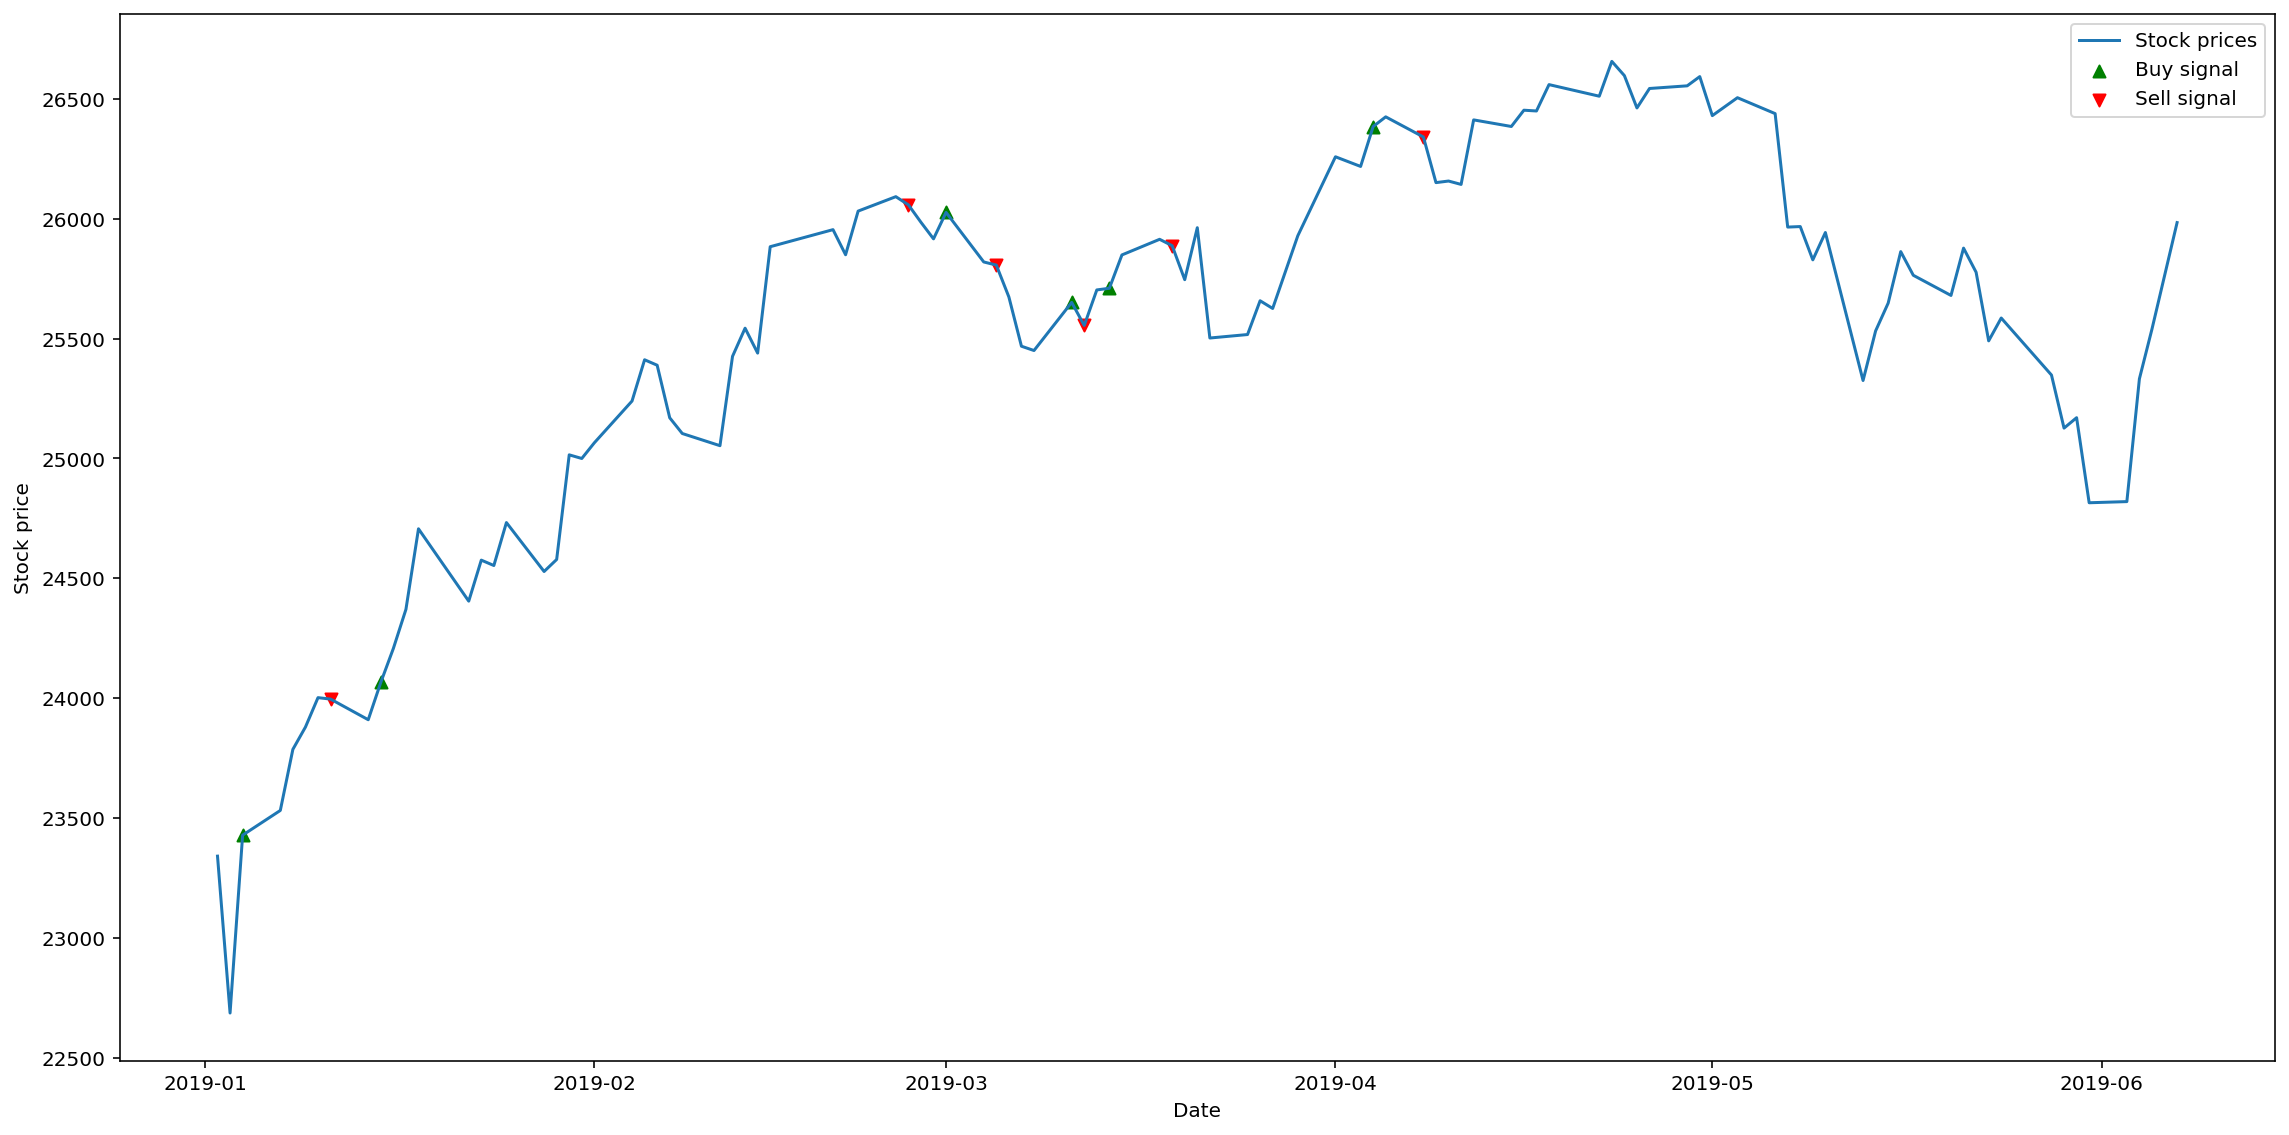

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	731   	-28.57  	18.4991	3.50042  	5.26207
2  	693   	-31.1341	18.4991	6.46354  	5.47454
3  	732   	-28.7657	18.4991	8.92049  	5.54966
4  	728   	-28.864 	18.4991	11.2933  	5.39127
5  	736   	-28.864 	18.4991	12.8923  	5.44027
6  	732   	-28.864 	19.3536	14.1042  	5.06125
7  	768   	-28.864 	19.9505	14.6425  	5.10215
8  	718   	-20.1856	19.9505	15.1139  	4.49489
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Best average net profit: 5.762319715497026
CPU times: user 9min, sys: 565 ms, total: 9min 1s
Wall time: 9min 2s


In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[2, 75, 95], [211], [54, 6]]
Net profit of strategy: 9.319400
Net profit of buy and hold: 5.462050
Percentage profit of strategy: 22.869693%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 13
Number of sell signals: 13


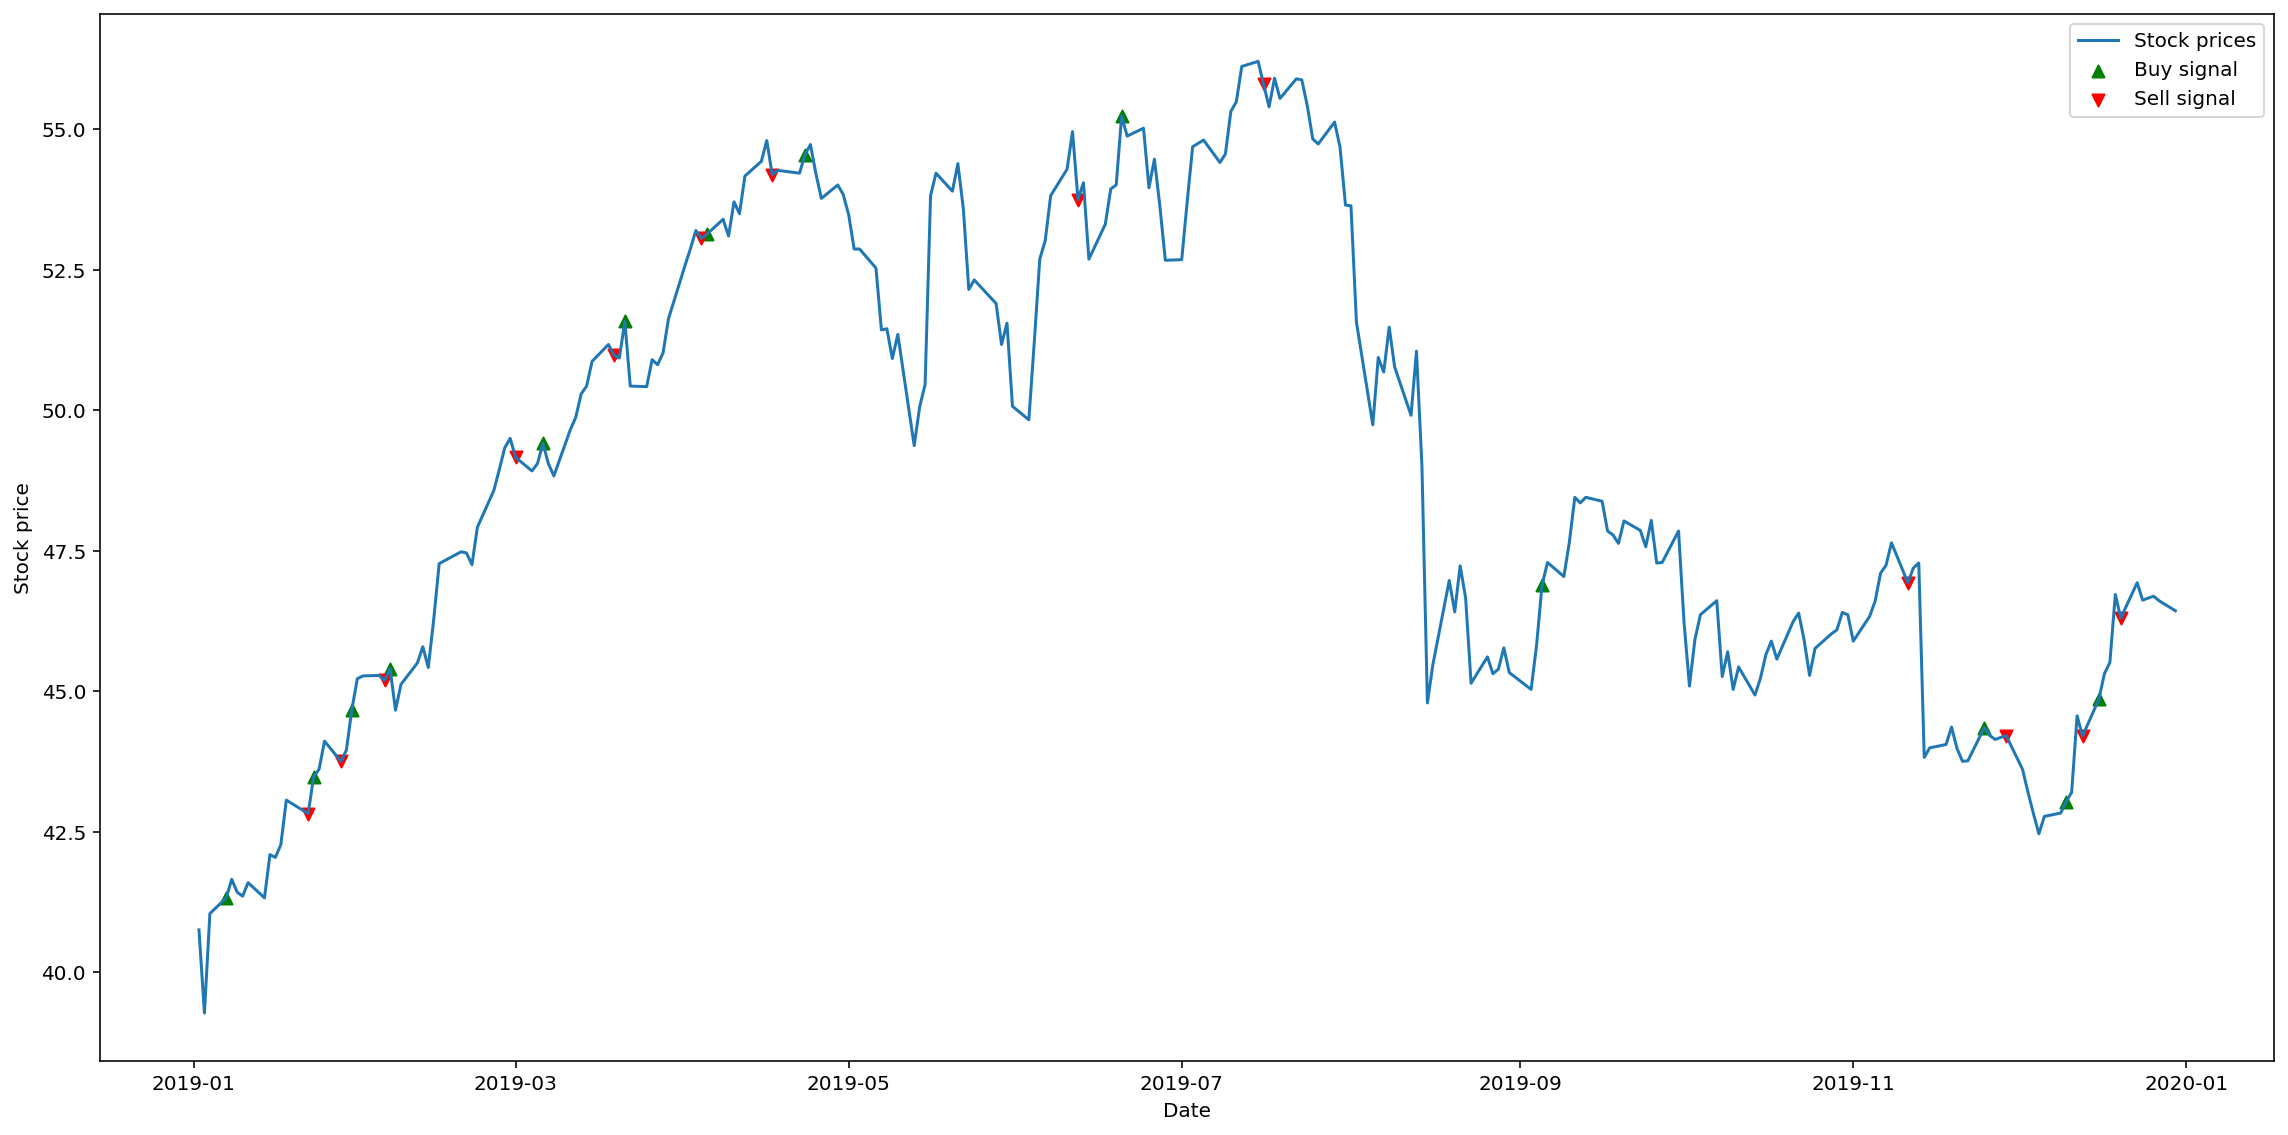

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	731   	-71.9984	28.6954	-8.75828	11.6008
2  	693   	-73.4446	28.6954	-2.11058	11.0829
3  	732   	-71.8792	28.6954	2.90854 	10.0403
4  	728   	-73.7501	30.9357	7.63493 	9.76254
5  	736   	-72.7027	31.7069	10.1381 	10.5647
6  	732   	-72.7027	34.6504	12.3223 	12.1433
7  	768   	-72.7027	41.1156	14.7834 	12.1551
8  	718   	-72.7027	44.309 	17.0772 	11.5354
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Best average net profit: 8.479595850697212
CPU times: user 8min 16s, sys: 1.02 s, total: 8min 17s
Wall time: 8min 17s


In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 39, 91], [5, 4]]
Net profit of strategy: -2.384825
Net profit of buy and hold: -13.107875
Percentage profit of strategy: -3.224479%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 2
Number of sell signals: 2


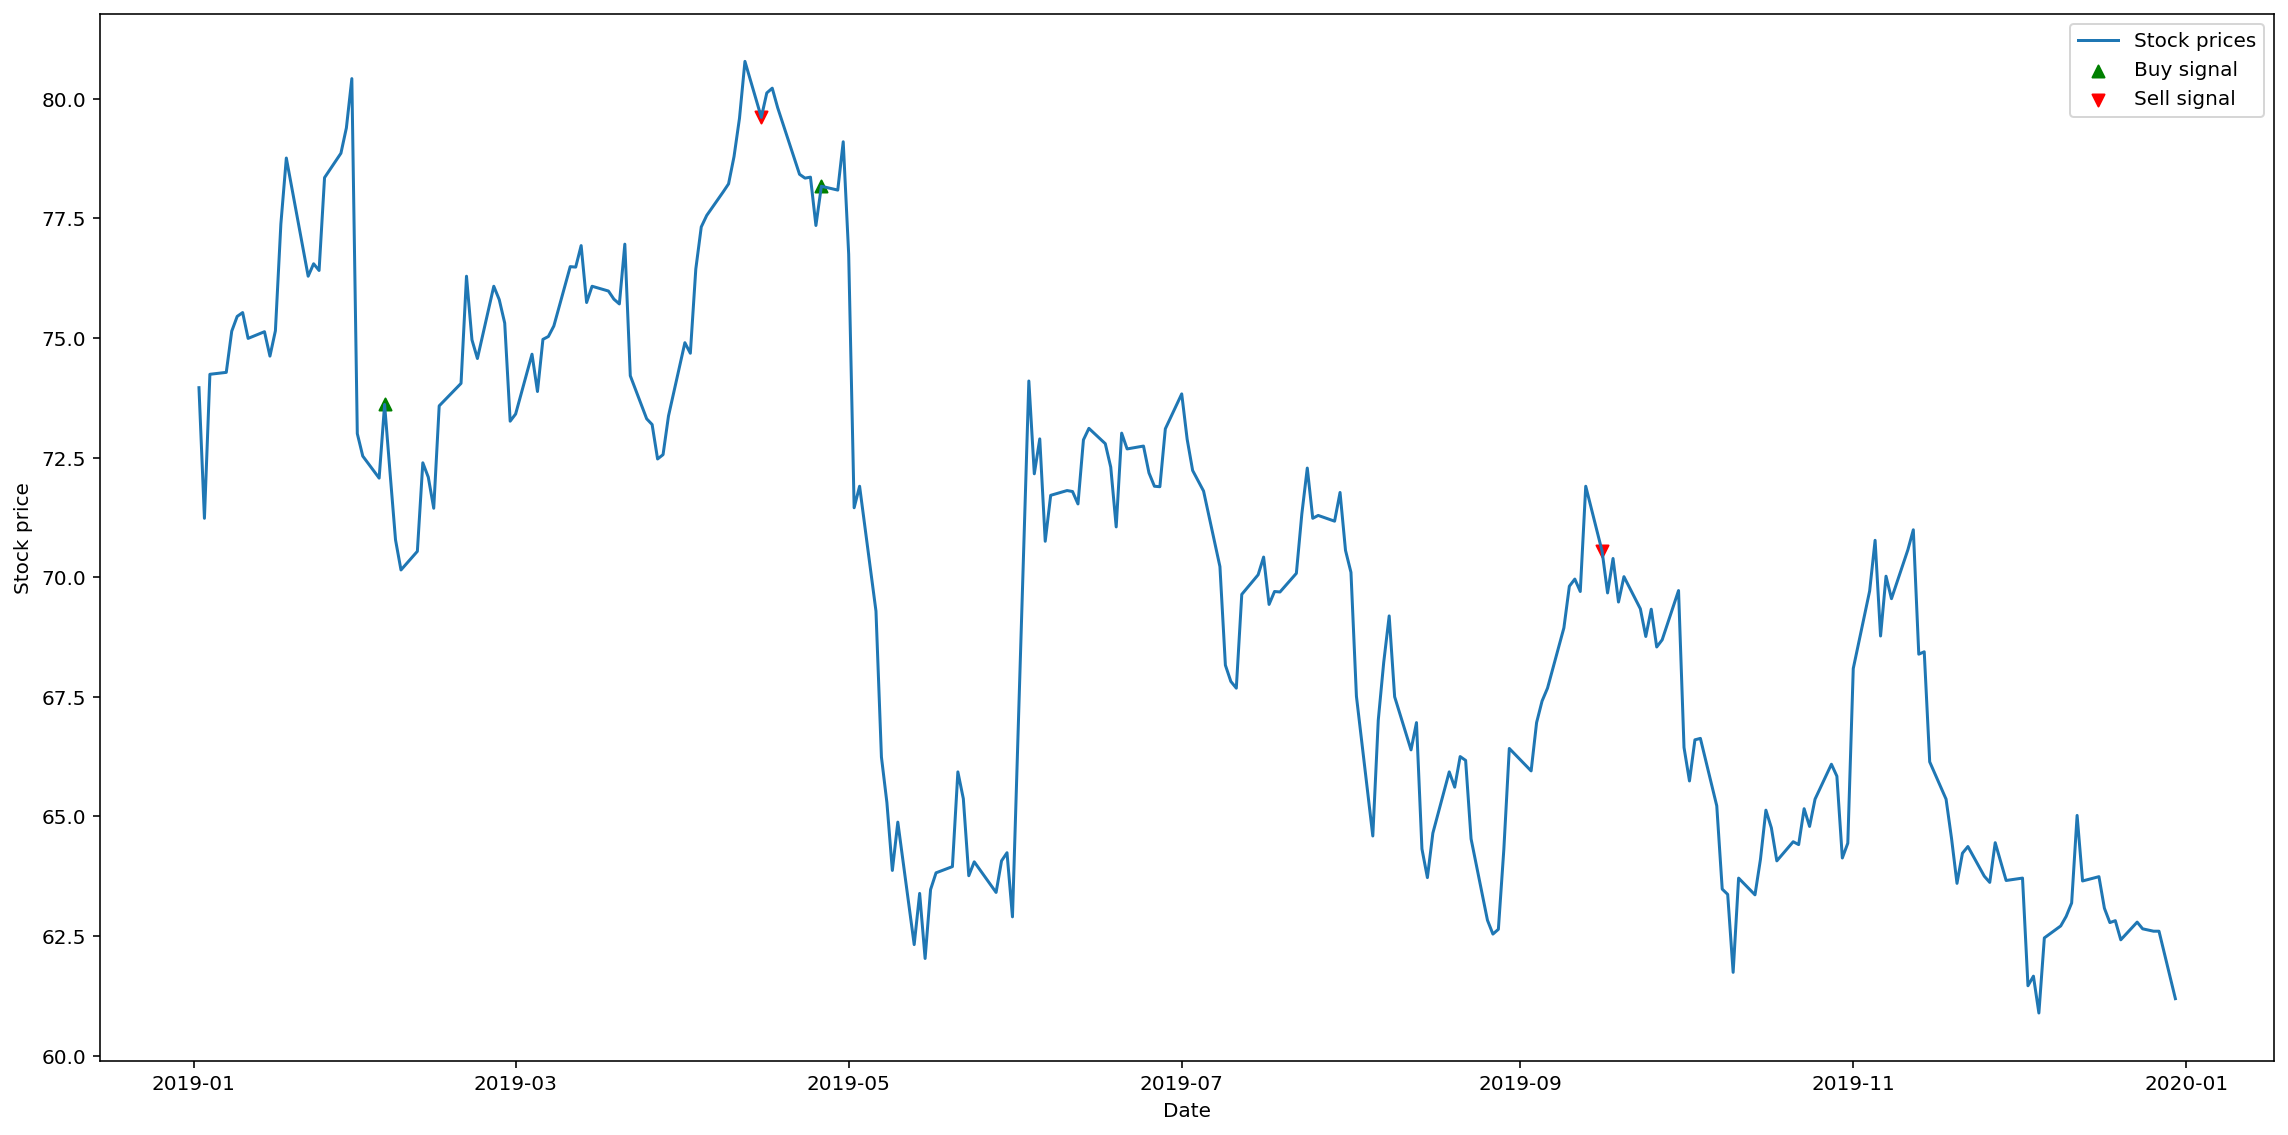

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	731   	-34.9271	37.1167	7.61161	11.1005
2  	693   	-85.9088	37.1167	13.1001	11.544 
3  	732   	-71.2428	37.1167	17.6021	12.0135
4  	728   	-71.2428	47.9687	21.1749	12.3887
5  	736   	-71.2428	47.9687	24.1325	12.5487
6  	732   	-71.2846	54.2107	26.5203	13.5914
7  	768   	-69.7673	54.6596	29.2844	13.3777
8  	718   	-70.1652	54.6596	32.482 	13.0998
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0]
Best average net profit: 17.618220268863666
CPU times: user 8min 35s, sys: 1.21 s, total: 8min 36s
Wall time: 8min 37s


In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 63, 91], [39, 5]]
Net profit of strategy: 20.541425
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 21.901509%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 4
Number of sell signals: 4


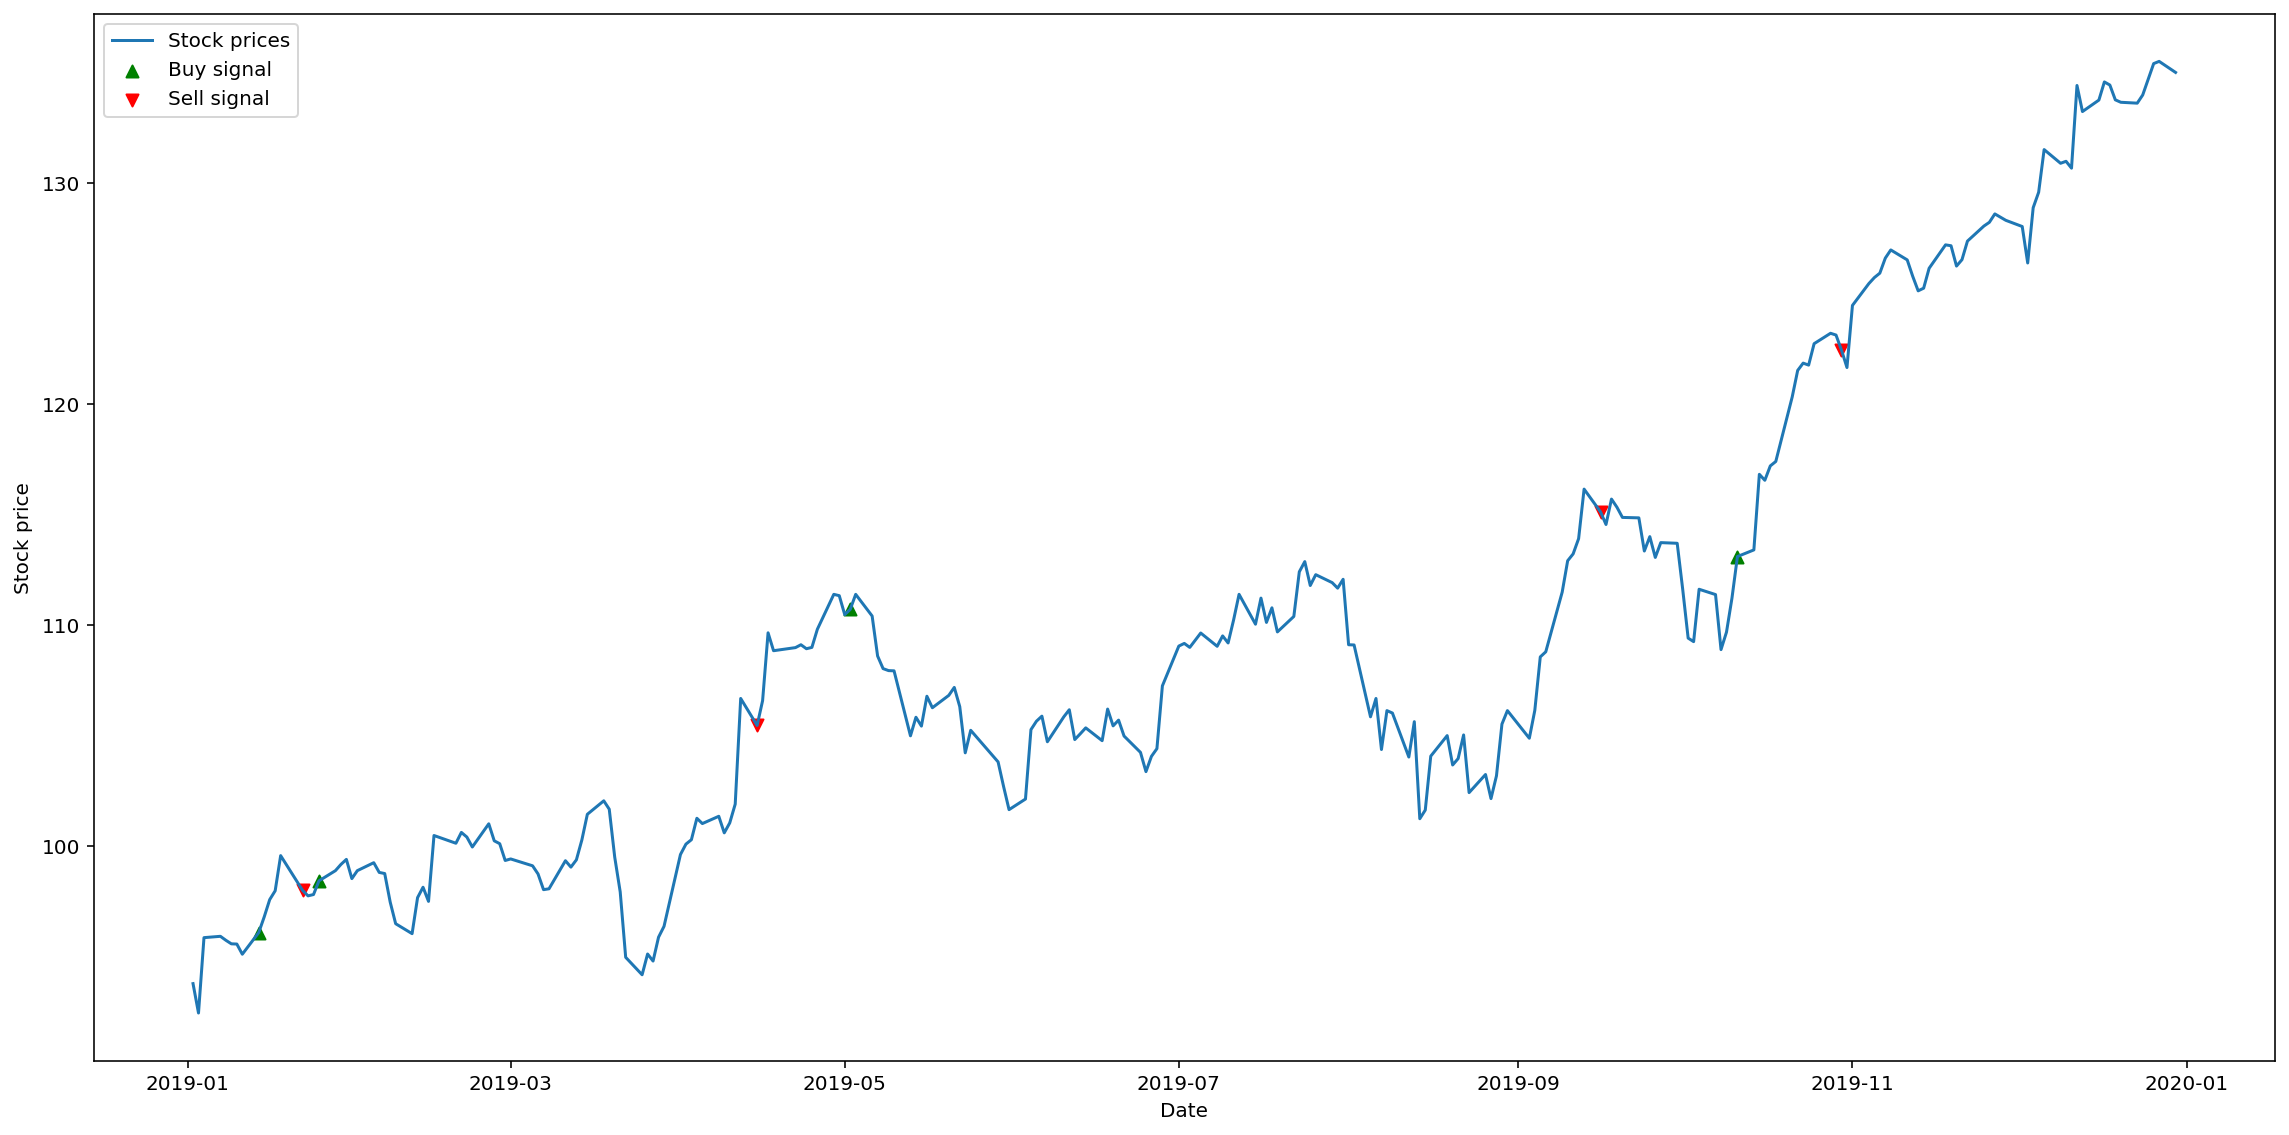

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	731   	-85.4313	49.0269	-2.02513	17.7733
2  	693   	-87.4818	49.0269	9.21054 	19.1424
3  	732   	-87.2022	50.6997	19.7663 	20.5208
4  	728   	-84.9165	50.6997	29.8714 	18.1563
5  	736   	-38.5937	51.7322	35.0353 	16.8602
6  	732   	-82.5612	54.4303	35.7068 	19.3098
7  	768   	-43.7544	54.4303	37.1464 	19.0636
8  	718   	-84.9165	54.7691	41.1466 	16.5524
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Best average net profit: -0.8710386251087537
CPU times: user 7min 10s, sys: 866 ms, total: 7min 11s
Wall time: 7min 12s


In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[116, 50, 78], [221], [33, 2]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 0
Number of sell signals: 0


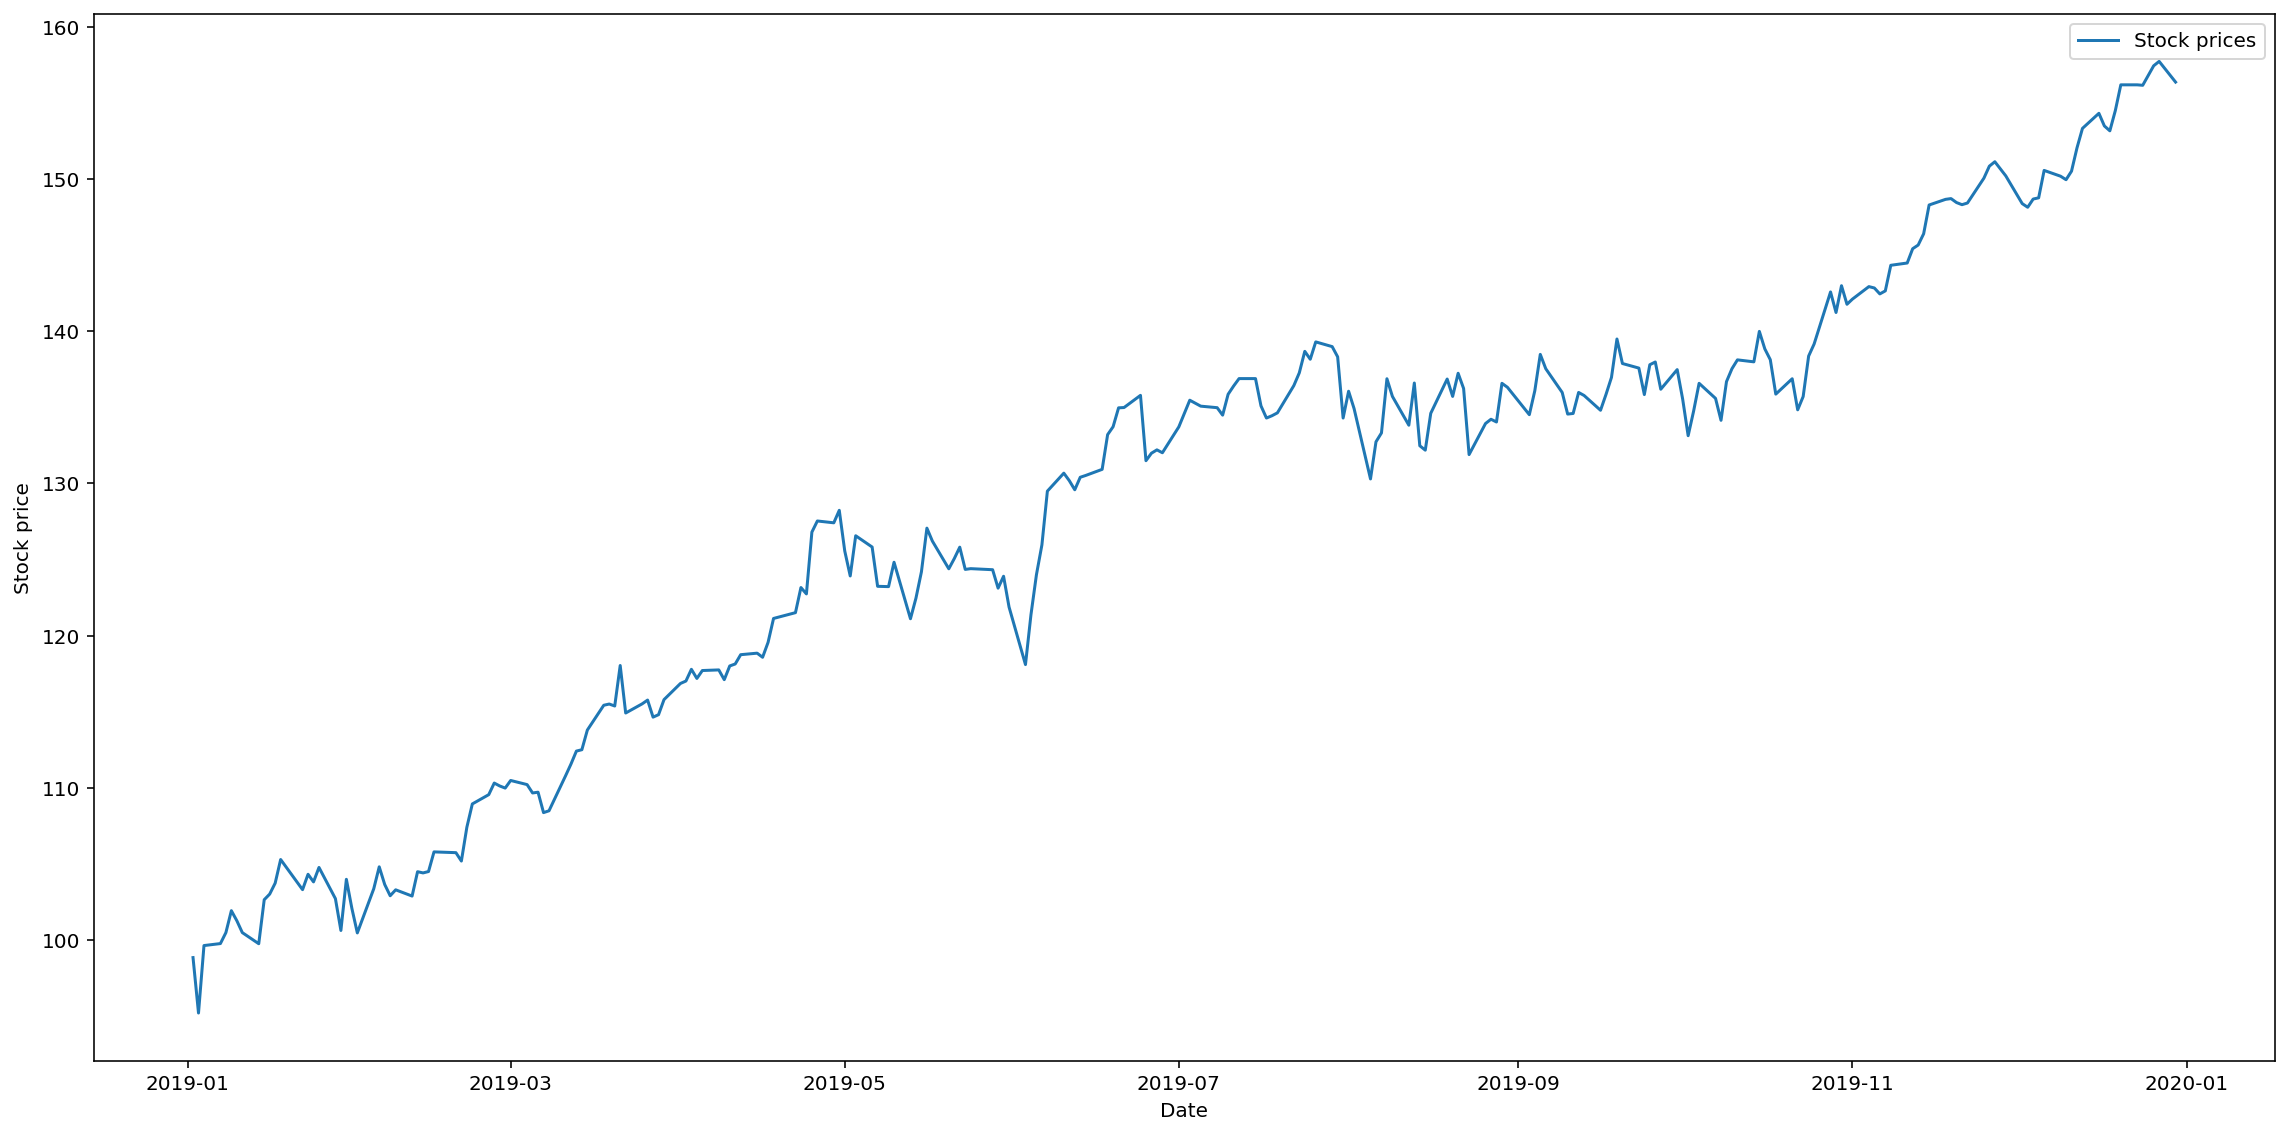

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	731   	-71.3157	20.4213	-6.69454	10.261 
2  	693   	-75.0377	29.2698	-0.96704	10.1276
3  	732   	-72.6723	31.4896	2.60763 	10.2653
4  	728   	-44.557 	31.4896	6.82478 	9.66486
5  	736   	-75.2574	33.8933	8.65344 	11.1483
6  	732   	-73.1451	34.0701	10.7492 	11.8584
7  	768   	-47.9721	34.0701	13.5114 	11.8751
8  	718   	-39.0605	35.753 	17.4606 	11.2883
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
Best average net profit: 1.8097794719227067
CPU times: user 9min 48s, sys: 1.31 s, total: 9min 49s
Wall time: 9min 50s


In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[220, 230], [59, 60, 25], [241], [50, 5]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 0
Number of sell signals: 0


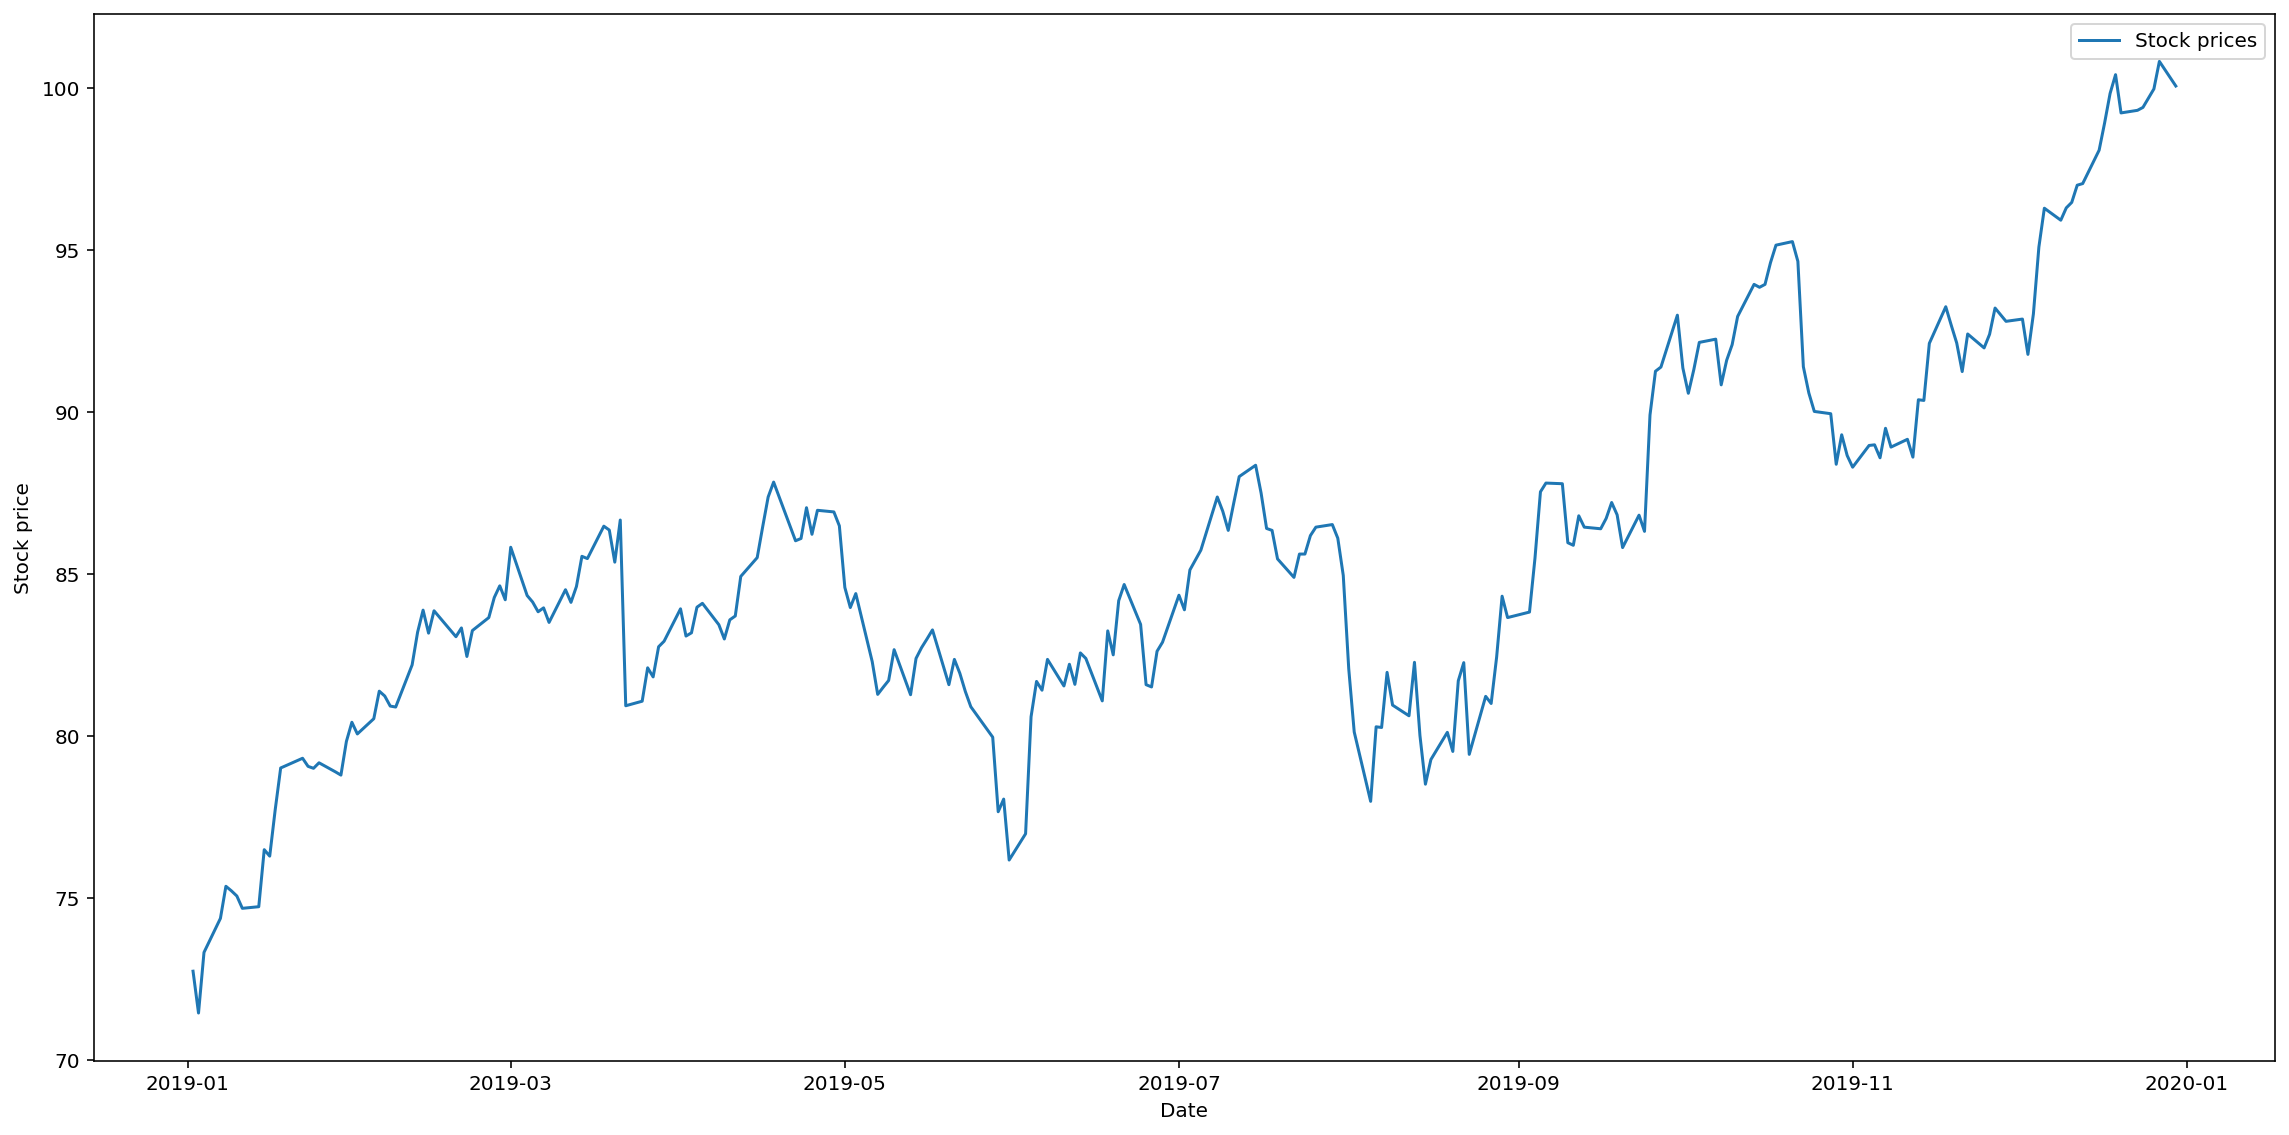

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=8)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	731   	-58.4832	133.353	25.746 	38.1755
2  	693   	-78.8268	133.353	47.4185	42.8753
3  	732   	-75.4362	147.224	75.422 	45.2584
4  	728   	-76.264 	145.216	99.2549	40.7056
5  	736   	-73.4602	145.216	113.624	35.7123
6  	732   	-53.81  	162.884	116.393	37.5027
7  	768   	-46.7194	169.576	117.069	38.7033
8  	718   	-76.434 	169.576	120.007	38.2872
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Best average net profit: 61.08166757956811
CPU times: user 9min 8s, sys: 1.15 s, total: 9min 9s
Wall time: 9min 10s


In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 55, 91], [37, 5]]
Net profit of strategy: 47.467325
Net profit of buy and hold: 52.403650
Percentage profit of strategy: 20.078391%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 4
Number of sell signals: 4


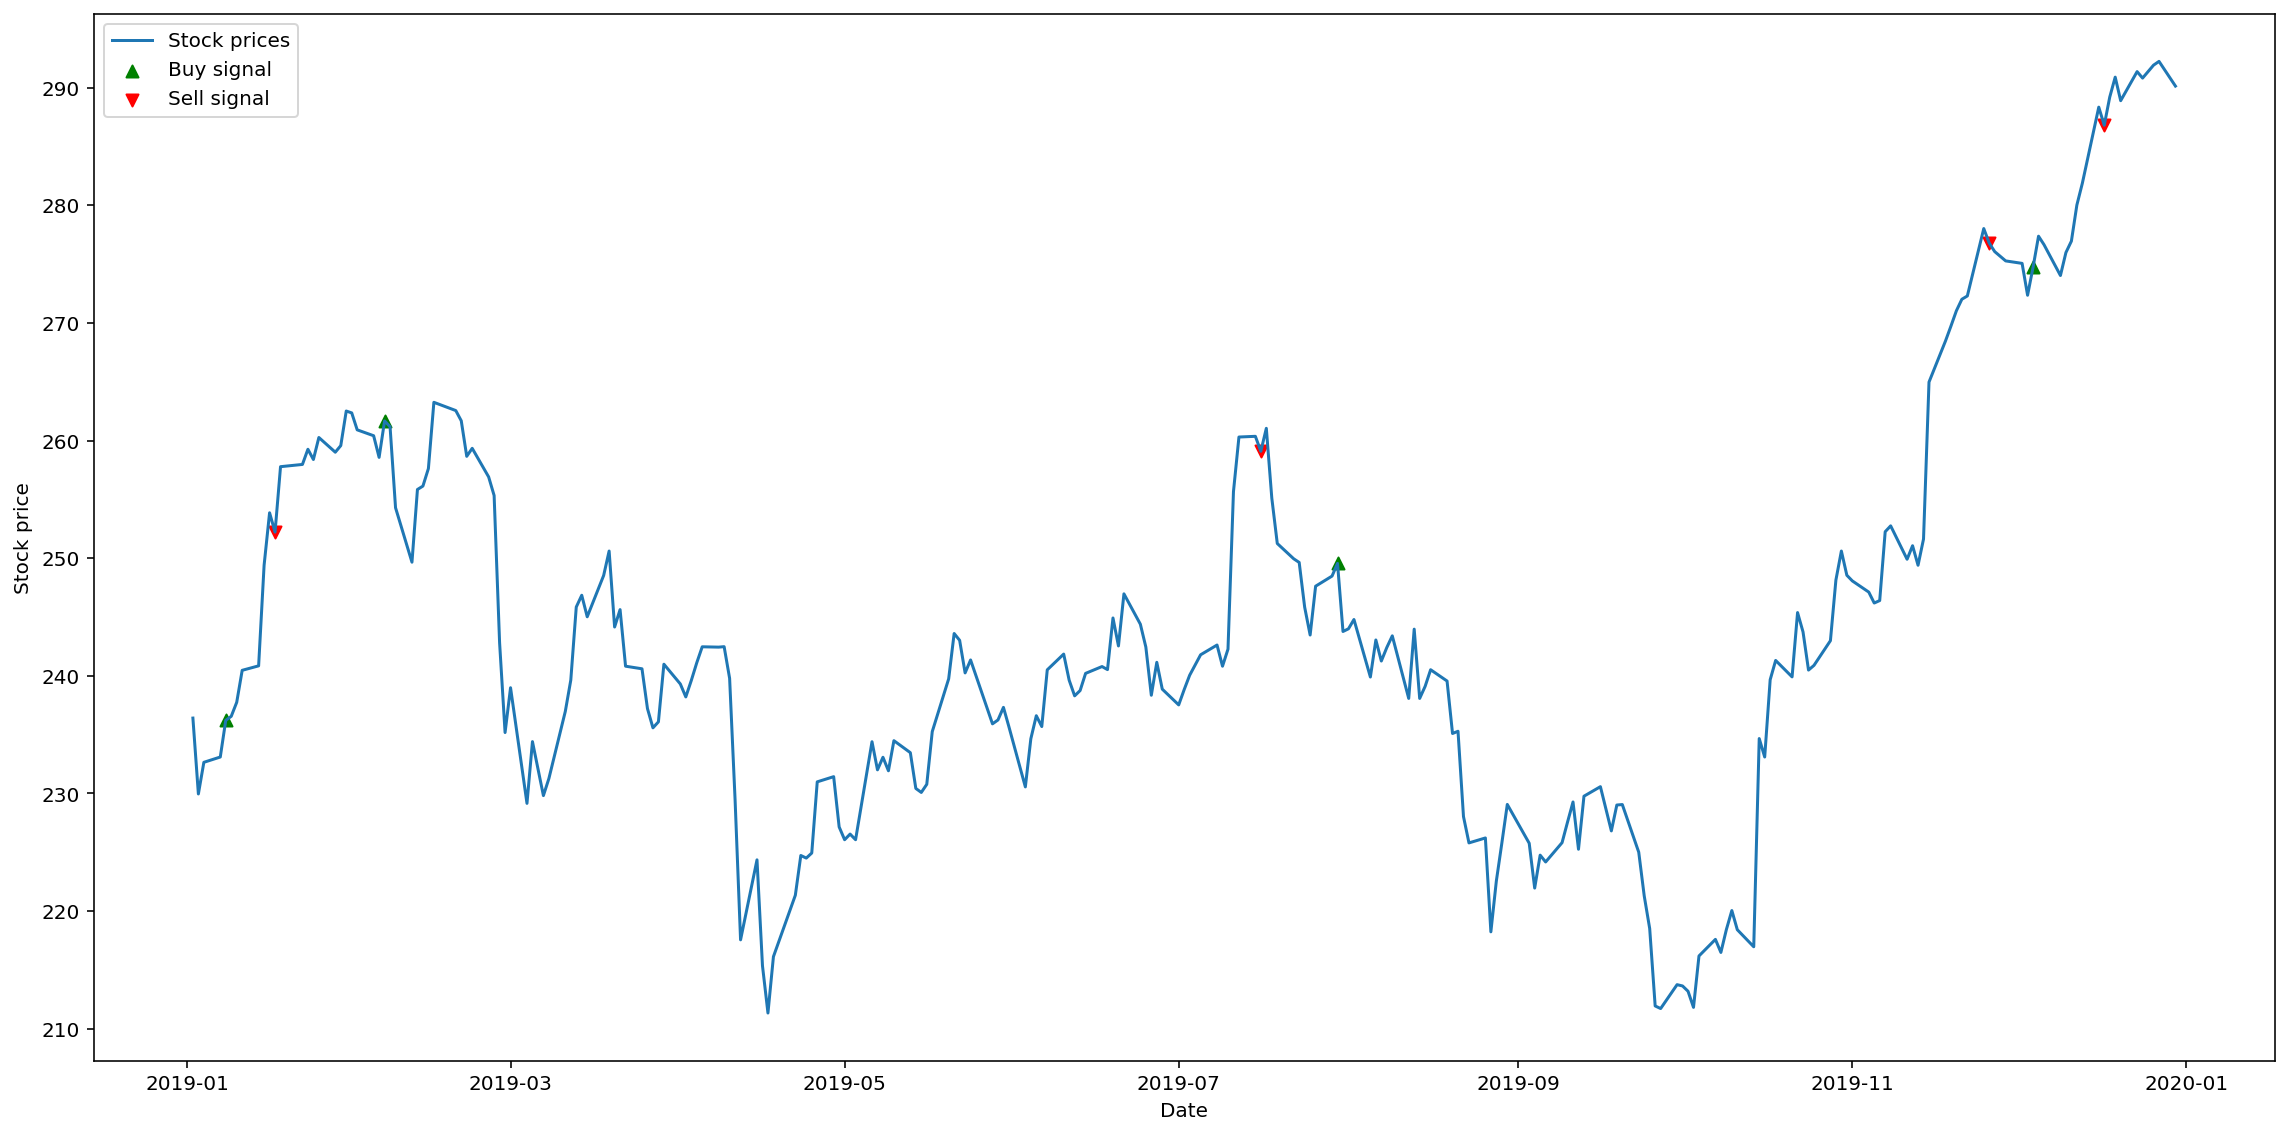

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[10.957437472575553, 24.010750329091714]","[23.037568689020972, 58.64860659414599]","[19.984333333333332, 29.842999999999996]","[9.459279368213295, 15.491510365251738]","[-0.91073968705548, -2.060810810810815]","[14.19640092879256, 2.4338235294117707]","[10.553376514333737, 39.54596977329974]","[6.922788305406461, 10.796113655545895]","[22.869693251533878, 13.403803680981593]","[-3.224479448350454, -17.72292455381287]","[21.901508689625754, 43.339375199914684]","[0.0, 57.507561197653246]","[0.0, 36.95081798185318]","[20.078391354003557, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

11.13039705510237

In [52]:
np.mean(bh_results)

23.882430279472867